###***Step 1: Install Necessary Libraries***

In [13]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


In [1]:
!pip install pyLDAvis
!pip install contractions autocorrect vaderSentiment bertopic plotly joblib emoji gensim umap-learn pyLDAvis transformers torch
!pip install matplotlib seaborn

###***Step 2: Import Libraries***

In [2]:
import pandas as pd
import re
import nltk
import emoji
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from bertopic import BERTopic
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from transformers import BertTokenizer, BertModel
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, SimpleRNN
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import torch
import gensim
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LSTM, GRU, Bidirectional, SimpleRNN, Conv1D, GlobalMaxPooling1D
import tensorflow.keras.backend as K


In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

###***Step 3: Define Models***

In [4]:
#@title ANN
def create_ann_model(input_shape):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))  # 3 classes: positive, negative, neutral
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
#@title LSTM
def create_lstm_model(input_length):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=input_length))
    model.add(LSTM(128))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
#@title GRU
def create_gru_model(input_length):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=input_length))
    model.add(GRU(128))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
#@title BiLSTM
def create_bilstm_model(input_length):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=input_length))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
#@title RNN
def create_rnn_model(input_length):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=input_length))
    model.add(SimpleRNN(128))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
#@title CNN
def create_cnn_model(input_length):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=input_length))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
def plot_training_history(history, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    print(f"{model_name} Model")
    print("Test Accuracy : " + str(accuracy))
    print("Test Precision : " + str(precision))
    print("Test Recall : " + str(recall))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Model Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# @title Step4: Loading and Preprocessing
df = pd.read_csv('/content/drive/MyDrive/project NLP/CombinedPakistanFloodsTweets.csv')

# Preprocessing functions
contractions_dict = {"can't": "cannot", "won't": "will not", "n't": " not"}  # Add more contractions as needed

def expand_contractions(text, contractions_dict):
    for word, replacement in contractions_dict.items():
        text = re.sub(r'\b{}\b'.format(word), replacement, text)
    return text

def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'@\w+', '', tweet)     # Remove mentions
    tweet = re.sub(r'#\w+', '', tweet)     # Remove hashtags
    tweet = re.sub(r'\d+', '', tweet)      # Remove numbers
    tweet = tweet.lower()                  # Convert to lowercase
    tweet = re.sub(r'[^\w\s]', '', tweet)  # Remove punctuation
    tweet = emoji.demojize(tweet)          # Convert emojis to text
    tweet = expand_contractions(tweet, contractions_dict)
    tweet = tweet.strip()                  # Remove leading/trailing whitespace
    return tweet

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
analyzer = SentimentIntensityAnalyzer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1]
    return ' '.join(tokens)

# Clean and preprocess the data
df['cleaned_text'] = df['content'].apply(clean_tweet)
df['processed_text'] = df['cleaned_text'].apply(preprocess_text)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
#@title Step 5: Data checking
print(df.head())
# print(df['cleaned_text'].head(5))
# print(df['processed_text'].head(5))

                                                 url  \
0  https://twitter.com/AliBhattiPPP/status/156978...   
1  https://twitter.com/HullioSikandar/status/1569...   
2  https://twitter.com/gnnhdofficial/status/15697...   
3  https://twitter.com/gtvnetworkhd/status/156977...   
4  https://twitter.com/iqleyaa/status/15697772963...   

                        date  \
0  2022-09-13 20:16:16+00:00   
1  2022-09-13 20:09:43+00:00   
2  2022-09-13 20:00:00+00:00   
3  2022-09-13 20:00:00+00:00   
4  2022-09-13 19:57:27+00:00   

                                             content  \
0  PPP MNA @DRMAHREENBHUTTO visited the free Medi...   
1  Sindh Local Govt Minister @SyedNasirHShah says...   
2  یو این ایچ سی آر کے 2 طیارے بھی مزید امدادی سا...   
3  پاکستان کے لیے امداد کا اعلان کیا ہے ، ڈونلڈ ب...   
4  We are raising funds for:\n\n•Food parcels= £3...   

                                     renderedContent                   id  \
0  PPP MNA @DRMAHREENBHUTTO visited the free Medi...  15

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
#@title Step 6: Sentiment Analysis
def get_sentiment(tweet):
    vader_sentiment = analyzer.polarity_scores(tweet)['compound']
    return vader_sentiment

df['sentiment'] = df['cleaned_text'].apply(get_sentiment)
df['sentiment_class'] = df['sentiment'].apply(lambda x: 1 if x > 0 else (0 if x < 0 else 2))  # 1: positive, 0: negative, 2: neutral

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
#@title Step 7: Feature Extraction TF-IDF and Tokenization
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_dtm = tfidf_vectorizer.fit_transform(df['processed_text'])

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['processed_text'])
sequences = tokenizer.texts_to_sequences(df['processed_text'])
padded_sequences = pad_sequences(sequences, maxlen=100)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
#@title Step 8: Preparing Data for Traing
from sklearn.model_selection import train_test_split

X_tfidf = tfidf_dtm.toarray()
X_bert = padded_sequences
y = df['sentiment_class'].values

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
X_train_bert, X_test_bert, y_train, y_test = train_test_split(X_bert, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ANN
Epoch 1/10
54/54 [==============================] - 5s 15ms/step - loss: 0.8552 - accuracy: 0.6107 - val_loss: 0.5798 - val_accuracy: 0.7488
Epoch 2/10
54/54 [==============================] - 0s 7ms/step - loss: 0.4014 - accuracy: 0.8485 - val_loss: 0.4273 - val_accuracy: 0.8209
Epoch 3/10
54/54 [==============================] - 0s 7ms/step - loss: 0.1811 - accuracy: 0.9528 - val_loss: 0.4360 - val_accuracy: 0.8419
Epoch 4/10
54/54 [==============================] - 0s 9ms/step - loss: 0.0808 - accuracy: 0.9825 - val_loss: 0.4991 - val_accuracy: 0.8326
Epoch 5/10
54/54 [==============================] - 0s 8ms/step - loss: 0.0396 - accuracy: 0.9924 - val_loss: 0.5502 - val_accuracy: 0.8419
Epoch 6/10
54/54 [==============================] - 1s 11ms/step - loss: 0.0267 - accuracy: 0.9965 - val_loss: 0.5865 - val_accuracy: 0.8395
Epoch 7/10
54/54 [==============================] - 1s 9ms/step - loss: 0.0209 - accuracy: 0.9959 - val_loss: 0.6020 - val_accuracy: 0.8419
Epoch 8/10
54/

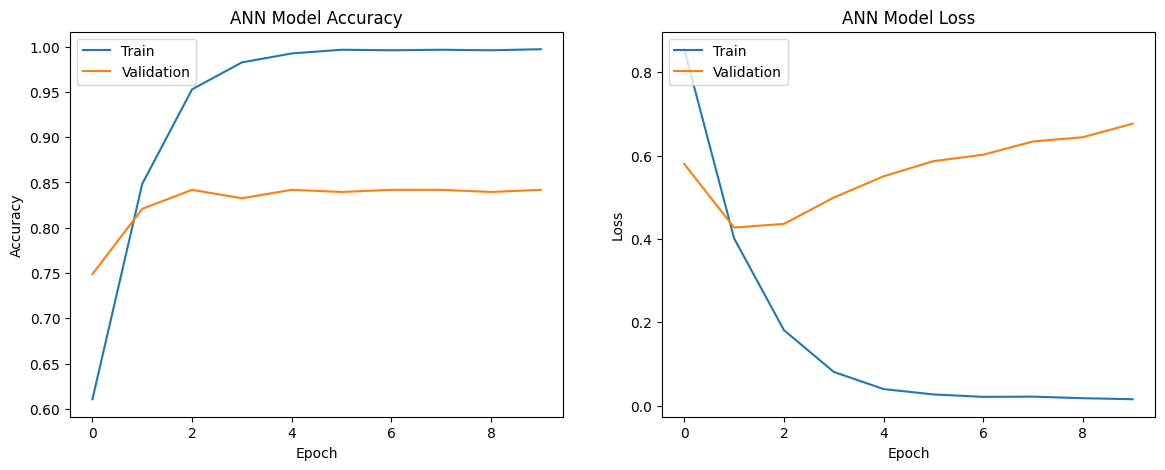

17/17 [==============================] - 0s 3ms/step
ANN Model
Test Accuracy : 0.851024208566108
Test Precision : 0.8579363846707536
Test Recall : 0.851024208566108


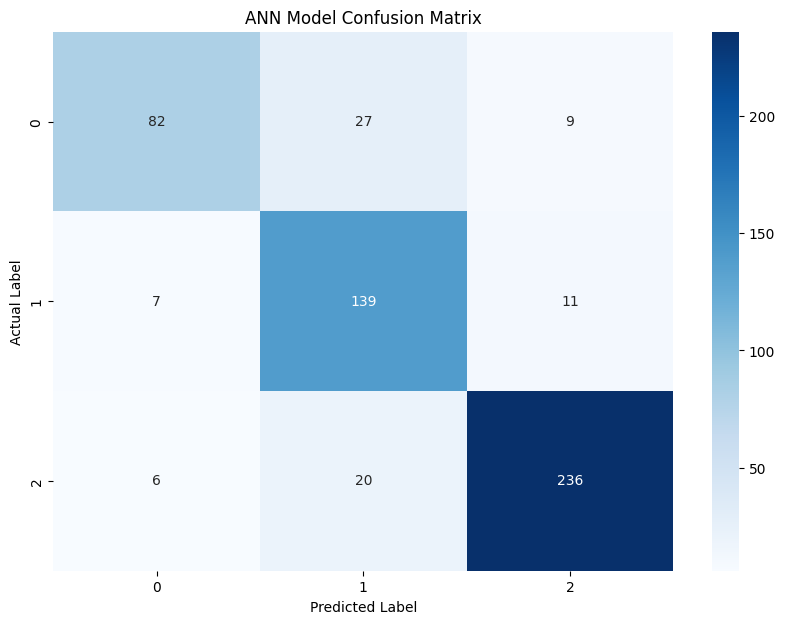

In [17]:
#@title Step 9: Train and evaluate ANN
print("ANN")
ann_model = create_ann_model(X_train_tfidf.shape[1])
history_ann = ann_model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_split=0.2 )
plot_training_history(history_ann, "ANN")
evaluate_model(ann_model, X_test_tfidf, y_test, "ANN")



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LSTM
Epoch 1/10
54/54 [==============================] - 18s 252ms/step - loss: 0.8079 - accuracy: 0.6573 - val_loss: 0.5801 - val_accuracy: 0.7512
Epoch 2/10
54/54 [==============================] - 8s 143ms/step - loss: 0.3672 - accuracy: 0.8531 - val_loss: 0.4755 - val_accuracy: 0.8023
Epoch 3/10
54/54 [==============================] - 8s 149ms/step - loss: 0.1622 - accuracy: 0.9528 - val_loss: 0.4930 - val_accuracy: 0.8349
Epoch 4/10
54/54 [==============================] - 3s 60ms/step - loss: 0.0698 - accuracy: 0.9819 - val_loss: 0.5501 - val_accuracy: 0.8419
Epoch 5/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0450 - accuracy: 0.9878 - val_loss: 0.5689 - val_accuracy: 0.8535
Epoch 6/10
54/54 [==============================] - 4s 67ms/step - loss: 0.0333 - accuracy: 0.9901 - val_loss: 0.6886 - val_accuracy: 0.8256
Epoch 7/10
54/54 [==============================] - 2s 43ms/step - loss: 0.0339 - accuracy: 0.9936 - val_loss: 0.5821 - val_accuracy: 0.8465
Epoc

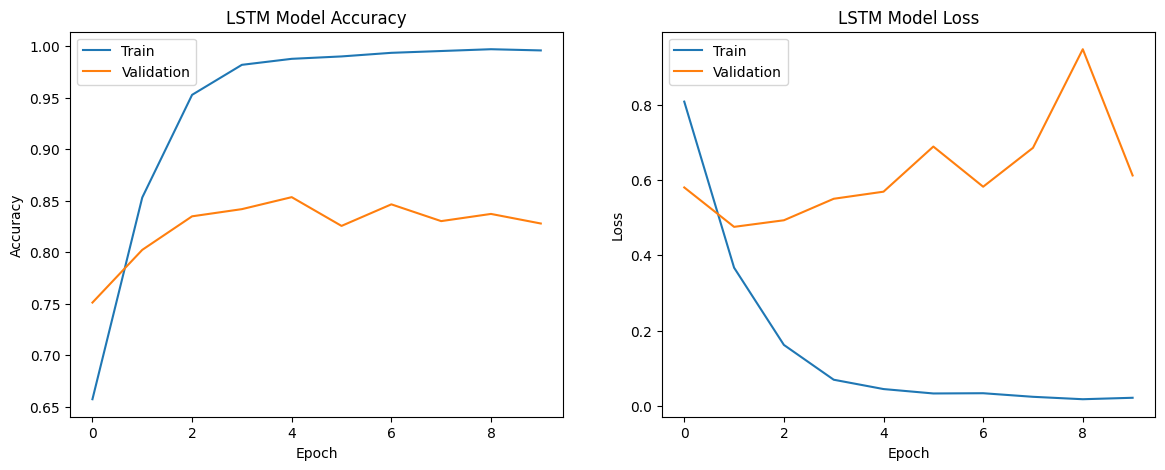

17/17 [==============================] - 1s 4ms/step
LSTM Model
Test Accuracy : 0.839851024208566
Test Precision : 0.8469119765610426
Test Recall : 0.839851024208566


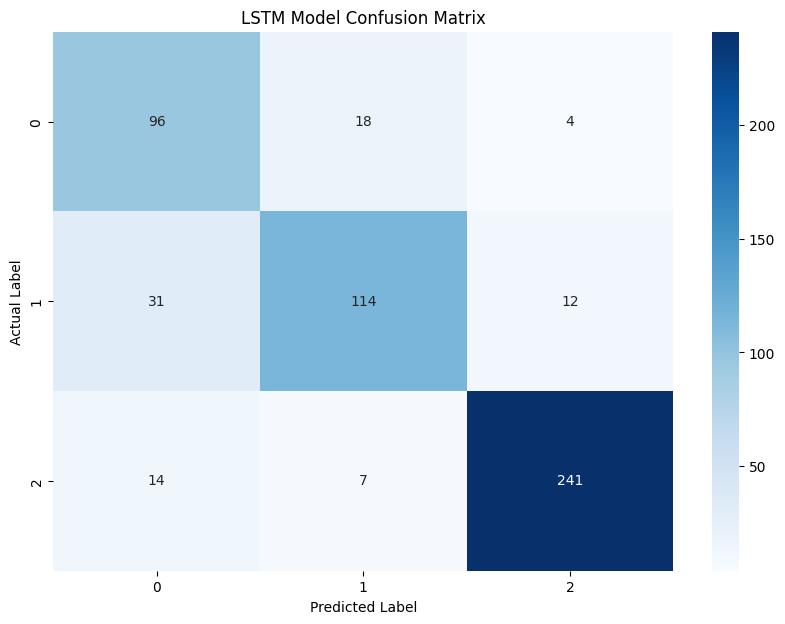

In [18]:
#@title Step 10: Train and evaluate LSTM
print("LSTM")
lstm_model = create_lstm_model(X_train_bert.shape[1])
history_lstm = lstm_model.fit(X_train_bert, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_lstm, "LSTM")
evaluate_model(lstm_model, X_test_bert, y_test, "LSTM")



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GRU
Epoch 1/10
54/54 [==============================] - 10s 160ms/step - loss: 0.8047 - accuracy: 0.6206 - val_loss: 0.5732 - val_accuracy: 0.7535
Epoch 2/10
54/54 [==============================] - 7s 129ms/step - loss: 0.3498 - accuracy: 0.8631 - val_loss: 0.4797 - val_accuracy: 0.8116
Epoch 3/10
54/54 [==============================] - 5s 92ms/step - loss: 0.1241 - accuracy: 0.9633 - val_loss: 0.5698 - val_accuracy: 0.8256
Epoch 4/10
54/54 [==============================] - 3s 58ms/step - loss: 0.0501 - accuracy: 0.9860 - val_loss: 0.5527 - val_accuracy: 0.8302
Epoch 5/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0307 - accuracy: 0.9930 - val_loss: 0.5897 - val_accuracy: 0.8395
Epoch 6/10
54/54 [==============================] - 2s 29ms/step - loss: 0.0226 - accuracy: 0.9930 - val_loss: 0.6035 - val_accuracy: 0.8326
Epoch 7/10
54/54 [==============================] - 1s 18ms/step - loss: 0.0115 - accuracy: 0.9983 - val_loss: 0.6644 - val_accuracy: 0.8419
Epoch 

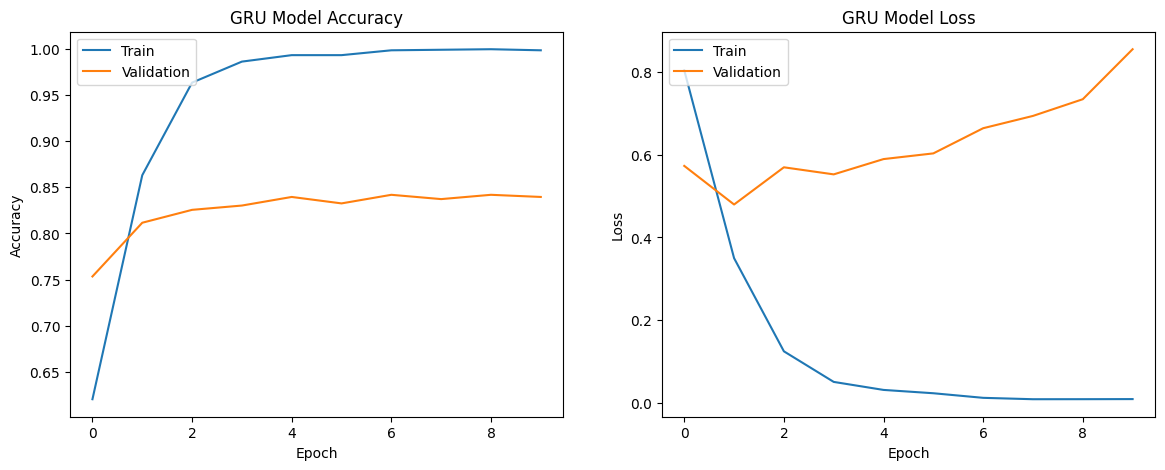

17/17 [==============================] - 1s 5ms/step
GRU Model
Test Accuracy : 0.845437616387337
Test Precision : 0.8478768406939502
Test Recall : 0.845437616387337


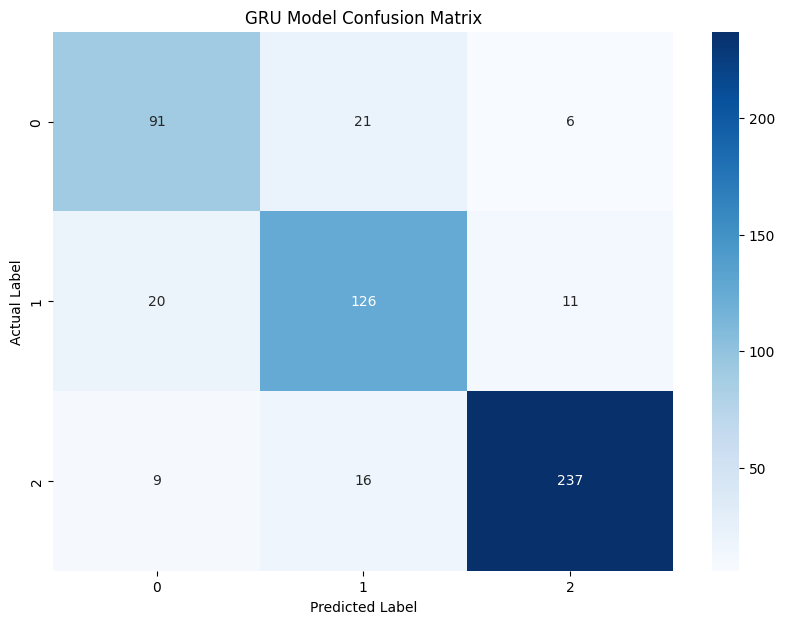

In [19]:
#@title Step 11: Train and evaluate GRU
print("GRU")
gru_model = create_gru_model(X_train_bert.shape[1])
history_gru = gru_model.fit(X_train_bert, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_gru, "GRU")
evaluate_model(gru_model, X_test_bert, y_test, "GRU")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


BiLSTM
Epoch 1/10
54/54 [==============================] - 18s 270ms/step - loss: 0.8140 - accuracy: 0.6282 - val_loss: 0.6100 - val_accuracy: 0.7023
Epoch 2/10
54/54 [==============================] - 8s 148ms/step - loss: 0.4237 - accuracy: 0.8153 - val_loss: 0.4888 - val_accuracy: 0.8000
Epoch 3/10
54/54 [==============================] - 8s 144ms/step - loss: 0.2099 - accuracy: 0.9318 - val_loss: 0.4755 - val_accuracy: 0.8256
Epoch 4/10
54/54 [==============================] - 5s 94ms/step - loss: 0.0933 - accuracy: 0.9732 - val_loss: 0.5278 - val_accuracy: 0.8279
Epoch 5/10
54/54 [==============================] - 5s 101ms/step - loss: 0.0550 - accuracy: 0.9831 - val_loss: 0.5238 - val_accuracy: 0.8256
Epoch 6/10
54/54 [==============================] - 3s 59ms/step - loss: 0.0376 - accuracy: 0.9901 - val_loss: 0.6292 - val_accuracy: 0.8047
Epoch 7/10
54/54 [==============================] - 2s 40ms/step - loss: 0.0394 - accuracy: 0.9918 - val_loss: 0.5914 - val_accuracy: 0.8395
E

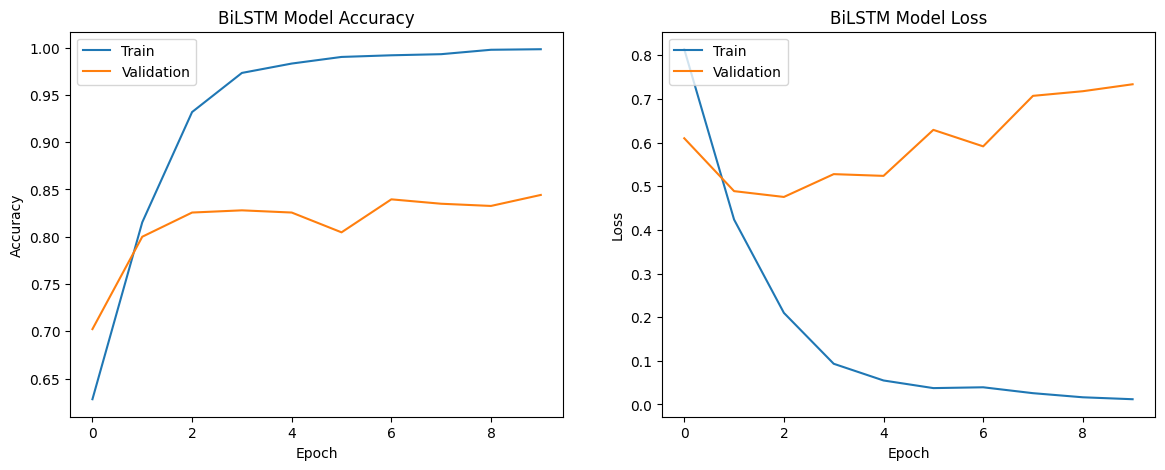

17/17 [==============================] - 1s 8ms/step
BiLSTM Model
Test Accuracy : 0.8417132216014898
Test Precision : 0.8459882579045592
Test Recall : 0.8417132216014898


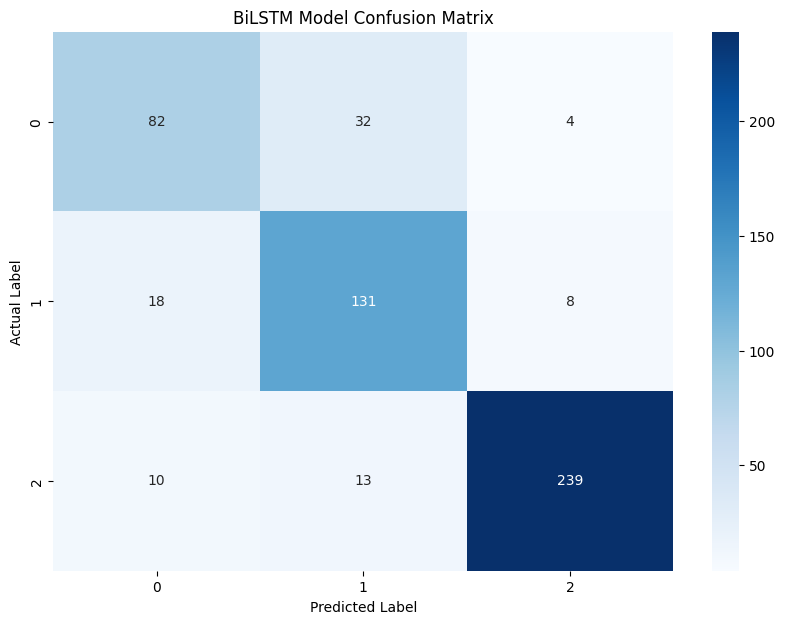

In [20]:
#@title Step 12: Train and evaluate BiLSTM
print("BiLSTM")
bilstm_model = create_bilstm_model(X_train_bert.shape[1])
history_bilstm = bilstm_model.fit(X_train_bert, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_bilstm, "BiLSTM")
evaluate_model(bilstm_model, X_test_bert, y_test, "BiLSTM")




RNN
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


54/54 [==============================] - 10s 166ms/step - loss: 0.8029 - accuracy: 0.6451 - val_loss: 0.6424 - val_accuracy: 0.7349
Epoch 2/10
54/54 [==============================] - 9s 168ms/step - loss: 0.3298 - accuracy: 0.8916 - val_loss: 0.5821 - val_accuracy: 0.7302
Epoch 3/10
54/54 [==============================] - 8s 147ms/step - loss: 0.1131 - accuracy: 0.9709 - val_loss: 0.6477 - val_accuracy: 0.7326
Epoch 4/10
54/54 [==============================] - 9s 164ms/step - loss: 0.3399 - accuracy: 0.8928 - val_loss: 1.8977 - val_accuracy: 0.2279
Epoch 5/10
54/54 [==============================] - 11s 203ms/step - loss: 0.4346 - accuracy: 0.8432 - val_loss: 0.5399 - val_accuracy: 0.7651
Epoch 6/10
54/54 [==============================] - 5s 96ms/step - loss: 0.2033 - accuracy: 0.9441 - val_loss: 0.5607 - val_accuracy: 0.7698
Epoch 7/10
54/54 [==============================] - 8s 148ms/step - loss: 0.1148 - accuracy: 0.9755 - val_loss: 0.5978 - val_accuracy: 0.7744
Epoch 8/10
54/54

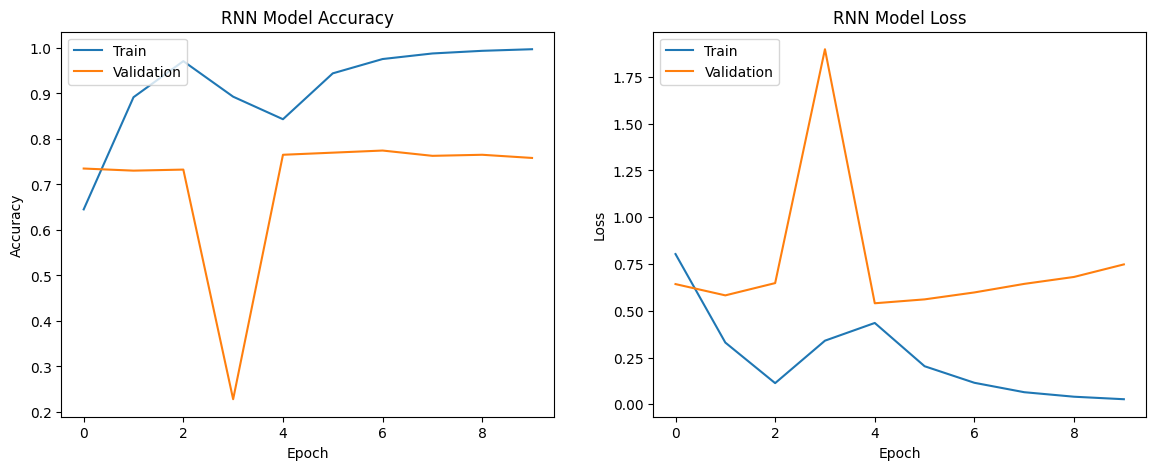

17/17 [==============================] - 0s 8ms/step
RNN Model
Test Accuracy : 0.8119180633147114
Test Precision : 0.8056024001134378
Test Recall : 0.8119180633147114


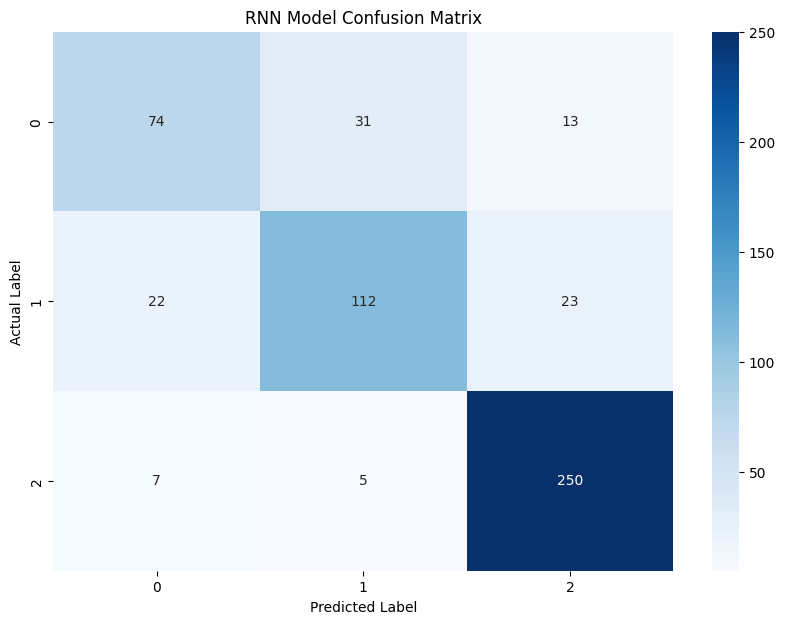

In [21]:
#@title Step 13: Train and evaluate RNN
print("RNN")
rnn_model = create_rnn_model(X_train_bert.shape[1])
history_rnn = rnn_model.fit(X_train_bert, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_rnn, "RNN")
evaluate_model(rnn_model, X_test_bert, y_test, "RNN")




CNN
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


54/54 [==============================] - 8s 123ms/step - loss: 0.9099 - accuracy: 0.5629 - val_loss: 0.6915 - val_accuracy: 0.7465
Epoch 2/10
54/54 [==============================] - 3s 63ms/step - loss: 0.4903 - accuracy: 0.8071 - val_loss: 0.5529 - val_accuracy: 0.7628
Epoch 3/10
54/54 [==============================] - 2s 44ms/step - loss: 0.2646 - accuracy: 0.9155 - val_loss: 0.4572 - val_accuracy: 0.8233
Epoch 4/10
54/54 [==============================] - 2s 31ms/step - loss: 0.1083 - accuracy: 0.9784 - val_loss: 0.4832 - val_accuracy: 0.8209
Epoch 5/10
54/54 [==============================] - 2s 44ms/step - loss: 0.0463 - accuracy: 0.9913 - val_loss: 0.5200 - val_accuracy: 0.8256
Epoch 6/10
54/54 [==============================] - 2s 36ms/step - loss: 0.0249 - accuracy: 0.9959 - val_loss: 0.5319 - val_accuracy: 0.8326
Epoch 7/10
54/54 [==============================] - 1s 16ms/step - loss: 0.0154 - accuracy: 0.9971 - val_loss: 0.5791 - val_accuracy: 0.8302
Epoch 8/10
54/54 [=====

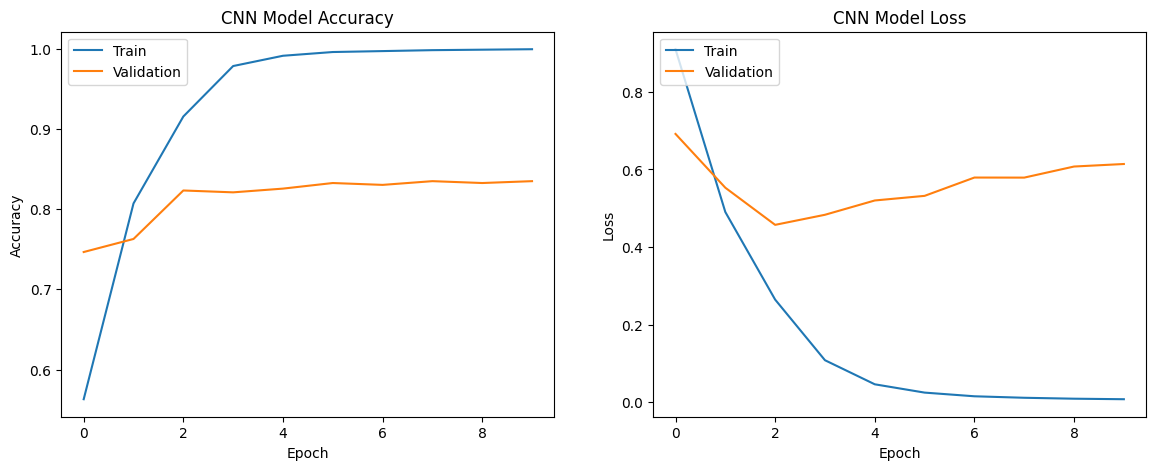

17/17 [==============================] - 0s 6ms/step
CNN Model
Test Accuracy : 0.8528864059590316
Test Precision : 0.8551265547498627
Test Recall : 0.8528864059590316


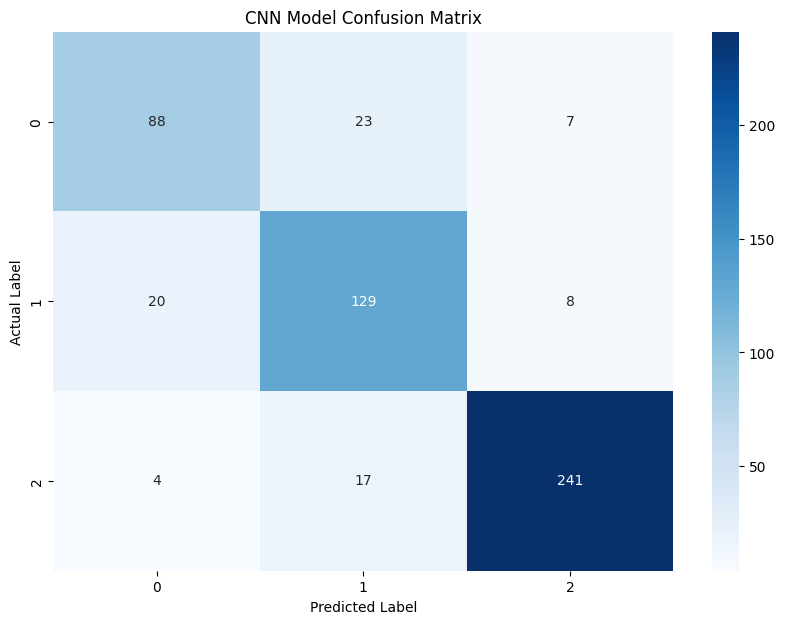

In [22]:
#@title Step 14: Train and evaluate CNN
print("CNN")
cnn_model = create_cnn_model(X_train_bert.shape[1])
history_cnn = cnn_model.fit(X_train_bert, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_cnn, "CNN")
evaluate_model(cnn_model, X_test_bert, y_test, "CNN")




###**Using BERT EMBEDDING**

In [23]:
#@title Step 1: Load Pre-trained DistilBERT Model
import torch
from transformers import DistilBertTokenizer, DistilBertModel

# Load pre-trained model tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Put the model in evaluation mode
model.eval()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [24]:
#@title Step 2: Preprocess and Generate BERT Embeddings
def get_distilbert_embedding(text):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')

    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Take the mean of the token embeddings to get a single embedding vector
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

# Apply the function to the dataset
df['distilbert_embedding'] = df['processed_text'].apply(get_distilbert_embedding)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
#@title Step 3: Split Data for Training and Testing
import numpy as np
from sklearn.model_selection import train_test_split

# Convert the list of embeddings to a numpy array
X = np.array(df['distilbert_embedding'].tolist())
y = df['sentiment_class'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
#@title Define Simple Model Training and Evaluation Functions
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score

# Logistic Regression Model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg, average='weighted')
print("Logistic Regression - Test Accuracy:", accuracy_logreg, "Precision:", precision_logreg)

# Support Vector Machine Model
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
print("SVM - Test Accuracy:", accuracy_svm, "Precision:", precision_svm)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Logistic Regression - Test Accuracy: 0.88268156424581 Precision: 0.8841563751431233
SVM - Test Accuracy: 0.8640595903165735 Precision: 0.8750414390389815


In [27]:
#@title Print results
print(f"Logistic Regression - Test Accuracy: {accuracy_logreg:.4f}, Precision: {precision_logreg:.4f}")
print(f"SVM - Test Accuracy: {accuracy_svm:.4f}, Precision: {precision_svm:.4f}")


Logistic Regression - Test Accuracy: 0.8827, Precision: 0.8842
SVM - Test Accuracy: 0.8641, Precision: 0.8750


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
#@title Step 4: Define Model Training and Evaluation Functions

from sklearn.metrics import accuracy_score, precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, SimpleRNN, Conv1D, GlobalMaxPooling1D

def create_ann_model(input_dim):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_lstm_model(input_dim):
    model = Sequential()
    model.add(LSTM(128, input_shape=(input_dim, 1), return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_gru_model(input_dim):
    model = Sequential()
    model.add(GRU(128, input_shape=(input_dim, 1), return_sequences=True))
    model.add(GRU(64))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_bilstm_model(input_dim):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(input_dim, 1)))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_rnn_model(input_dim):
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=(input_dim, 1), return_sequences=True))
    model.add(SimpleRNN(64))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_cnn_model(input_dim):
    model = Sequential()
    model.add(Conv1D(128, 3, activation='relu', input_shape=(input_dim, 1)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ANN
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


54/54 [==============================] - 2s 10ms/step - loss: 0.5694 - accuracy: 0.7517 - val_loss: 0.4889 - val_accuracy: 0.8070
Epoch 2/10
54/54 [==============================] - 0s 6ms/step - loss: 0.4052 - accuracy: 0.8304 - val_loss: 0.4738 - val_accuracy: 0.8140
Epoch 3/10
54/54 [==============================] - 0s 6ms/step - loss: 0.3497 - accuracy: 0.8625 - val_loss: 0.4640 - val_accuracy: 0.8186
Epoch 4/10
54/54 [==============================] - 0s 6ms/step - loss: 0.3144 - accuracy: 0.8700 - val_loss: 0.5000 - val_accuracy: 0.8186
Epoch 5/10
54/54 [==============================] - 0s 6ms/step - loss: 0.2879 - accuracy: 0.8846 - val_loss: 0.4638 - val_accuracy: 0.8302
Epoch 6/10
54/54 [==============================] - 0s 7ms/step - loss: 0.2504 - accuracy: 0.9079 - val_loss: 0.5039 - val_accuracy: 0.8163
Epoch 7/10
54/54 [==============================] - 0s 6ms/step - loss: 0.2337 - accuracy: 0.9138 - val_loss: 0.4829 - val_accuracy: 0.8233
Epoch 8/10
54/54 [============

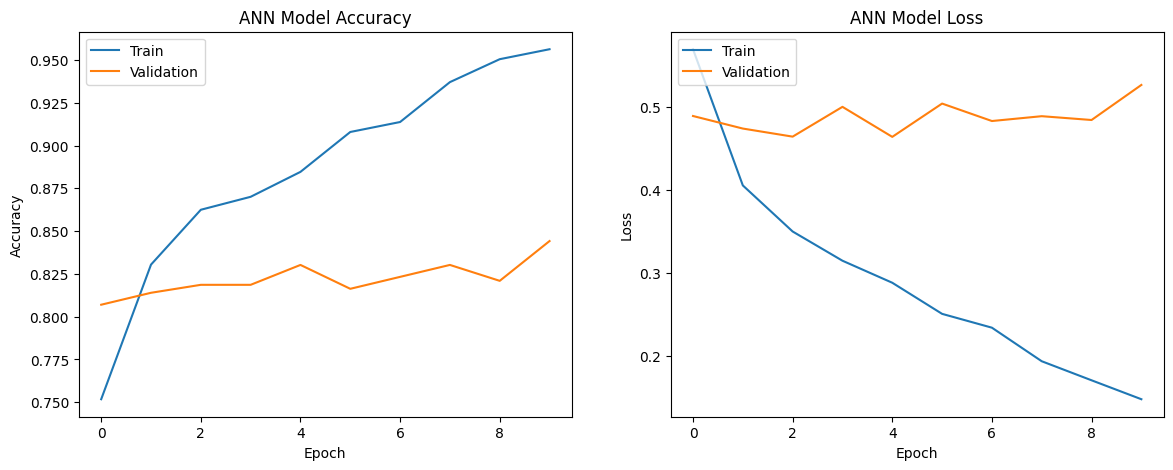

17/17 [==============================] - 0s 2ms/step
ANN Model
Test Accuracy : 0.8770949720670391
Test Precision : 0.8794976515800272
Test Recall : 0.8770949720670391


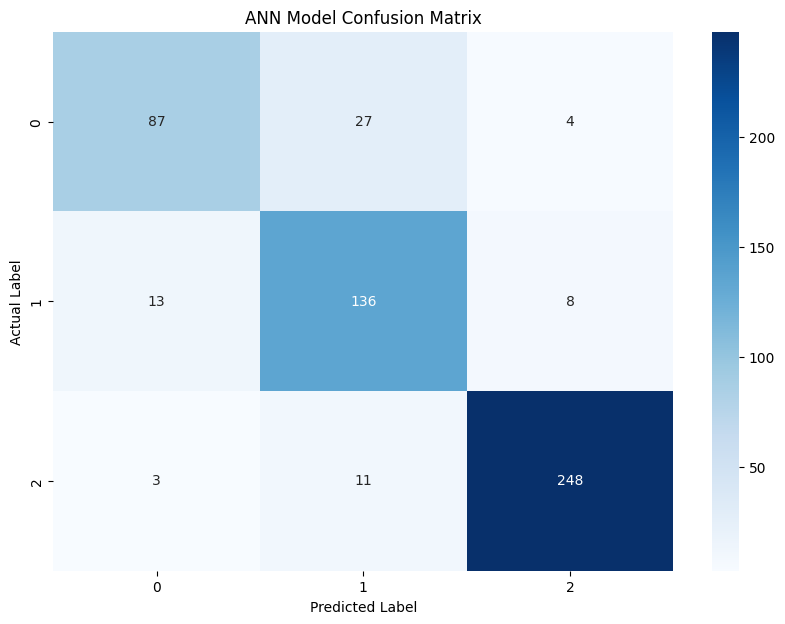

LSTM
Epoch 1/10
54/54 [==============================] - 7s 63ms/step - loss: 1.3097 - accuracy: 0.4790 - val_loss: 0.9355 - val_accuracy: 0.5605
Epoch 2/10
54/54 [==============================] - 3s 60ms/step - loss: 0.8111 - accuracy: 0.6031 - val_loss: 0.7308 - val_accuracy: 0.6884
Epoch 3/10
54/54 [==============================] - 3s 56ms/step - loss: 0.7194 - accuracy: 0.6812 - val_loss: 0.7548 - val_accuracy: 0.6721
Epoch 4/10
54/54 [==============================] - 3s 48ms/step - loss: 0.7045 - accuracy: 0.6754 - val_loss: 0.7038 - val_accuracy: 0.6907
Epoch 5/10
54/54 [==============================] - 3s 48ms/step - loss: 0.6811 - accuracy: 0.6760 - val_loss: 0.6775 - val_accuracy: 0.7000
Epoch 6/10
54/54 [==============================] - 3s 48ms/step - loss: 0.6883 - accuracy: 0.6876 - val_loss: 0.6994 - val_accuracy: 0.6907
Epoch 7/10
54/54 [==============================] - 3s 59ms/step - loss: 0.6641 - accuracy: 0.6987 - val_loss: 0.6310 - val_accuracy: 0.7233
Epoch 8/

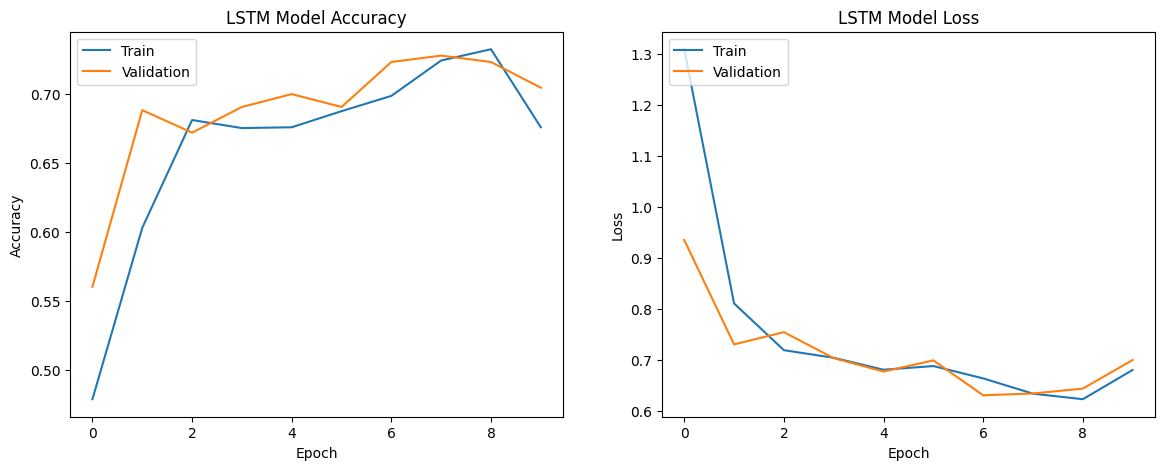

17/17 [==============================] - 2s 27ms/step
LSTM Model
Test Accuracy : 0.6759776536312849
Test Precision : 0.6073375849912163
Test Recall : 0.6759776536312849


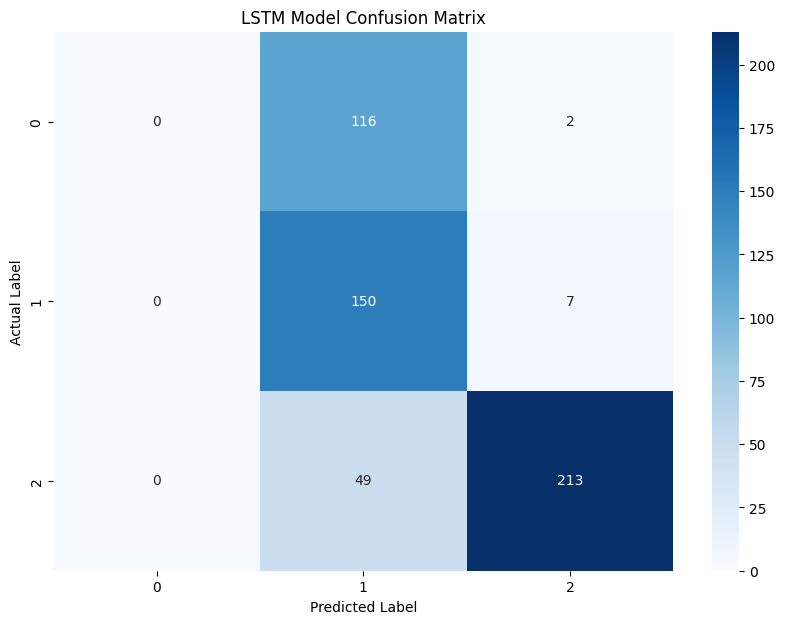

GRU
Epoch 1/10
54/54 [==============================] - 8s 63ms/step - loss: 0.9812 - accuracy: 0.5530 - val_loss: 0.7194 - val_accuracy: 0.7023
Epoch 2/10
54/54 [==============================] - 3s 47ms/step - loss: 0.6942 - accuracy: 0.6789 - val_loss: 0.6792 - val_accuracy: 0.6953
Epoch 3/10
54/54 [==============================] - 3s 47ms/step - loss: 0.6795 - accuracy: 0.6824 - val_loss: 0.6667 - val_accuracy: 0.7047
Epoch 4/10
54/54 [==============================] - 3s 48ms/step - loss: 0.6680 - accuracy: 0.6841 - val_loss: 0.6634 - val_accuracy: 0.7000
Epoch 5/10
54/54 [==============================] - 3s 58ms/step - loss: 0.6619 - accuracy: 0.6876 - val_loss: 0.6493 - val_accuracy: 0.7093
Epoch 6/10
54/54 [==============================] - 3s 50ms/step - loss: 0.6742 - accuracy: 0.6830 - val_loss: 0.6427 - val_accuracy: 0.7116
Epoch 7/10
54/54 [==============================] - 3s 48ms/step - loss: 0.6680 - accuracy: 0.6725 - val_loss: 0.6403 - val_accuracy: 0.6907
Epoch 8/1

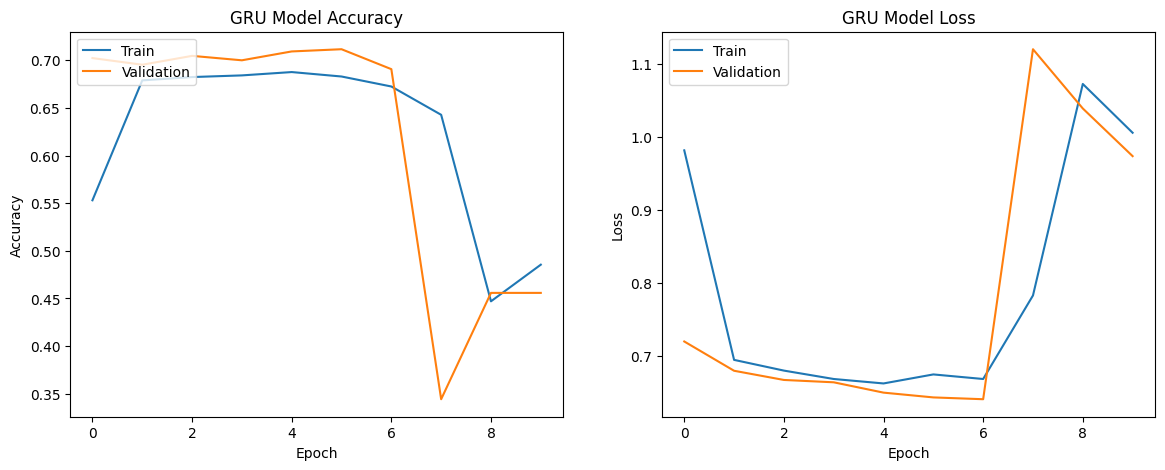

17/17 [==============================] - 1s 18ms/step
GRU Model
Test Accuracy : 0.48789571694599626
Test Precision : 0.23804223061424773
Test Recall : 0.48789571694599626


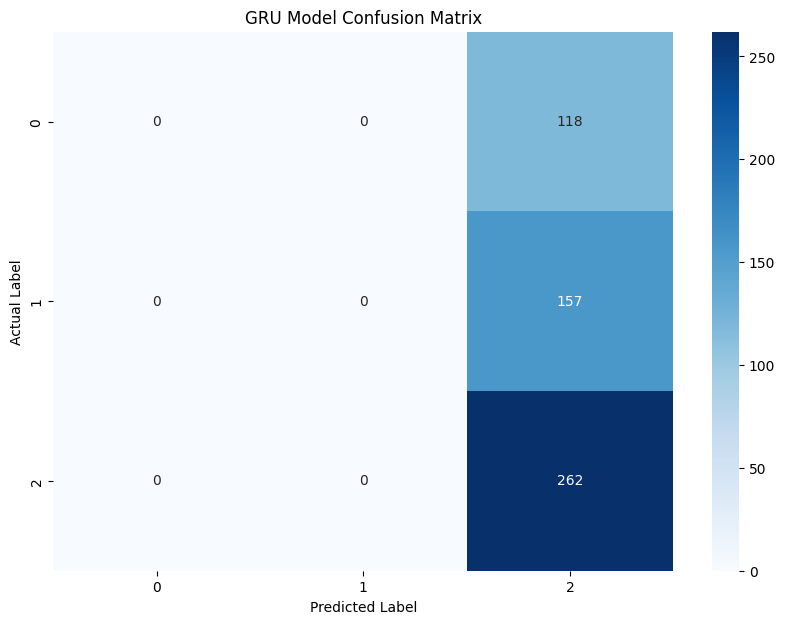

BiLSTM
Epoch 1/10
54/54 [==============================] - 13s 140ms/step - loss: 0.8356 - accuracy: 0.6212 - val_loss: 0.6600 - val_accuracy: 0.7000
Epoch 2/10
54/54 [==============================] - 5s 96ms/step - loss: 0.6605 - accuracy: 0.6737 - val_loss: 0.6651 - val_accuracy: 0.7000
Epoch 3/10
54/54 [==============================] - 6s 103ms/step - loss: 0.6339 - accuracy: 0.7005 - val_loss: 0.6630 - val_accuracy: 0.7209
Epoch 4/10
54/54 [==============================] - 6s 107ms/step - loss: 0.6264 - accuracy: 0.7290 - val_loss: 0.6504 - val_accuracy: 0.7116
Epoch 5/10
54/54 [==============================] - 5s 97ms/step - loss: 0.6153 - accuracy: 0.7354 - val_loss: 0.6215 - val_accuracy: 0.7000
Epoch 6/10
54/54 [==============================] - 6s 108ms/step - loss: 0.5946 - accuracy: 0.7383 - val_loss: 0.6195 - val_accuracy: 0.7209
Epoch 7/10
54/54 [==============================] - 5s 97ms/step - loss: 0.5744 - accuracy: 0.7500 - val_loss: 0.6272 - val_accuracy: 0.7070
E

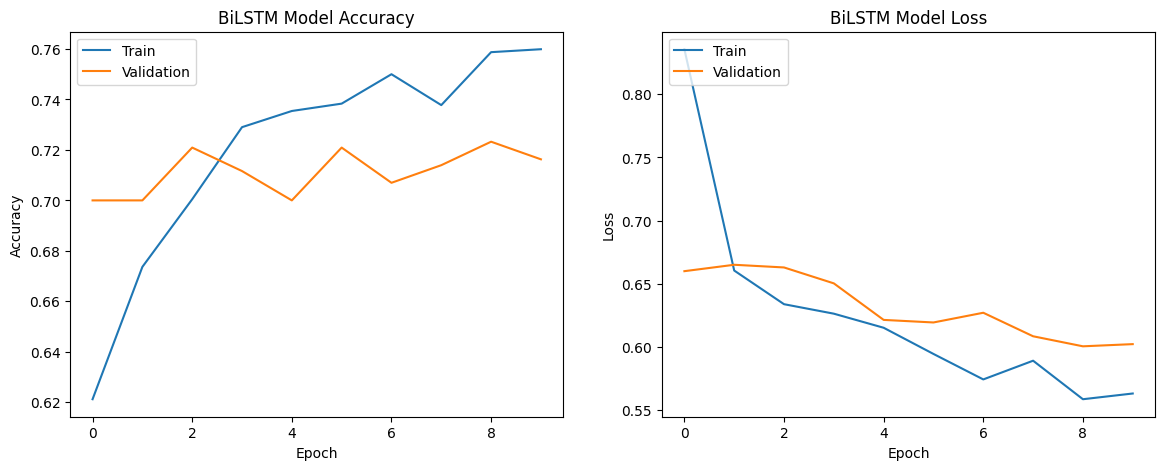

17/17 [==============================] - 2s 41ms/step
BiLSTM Model
Test Accuracy : 0.750465549348231
Test Precision : 0.8148729461675306
Test Recall : 0.750465549348231


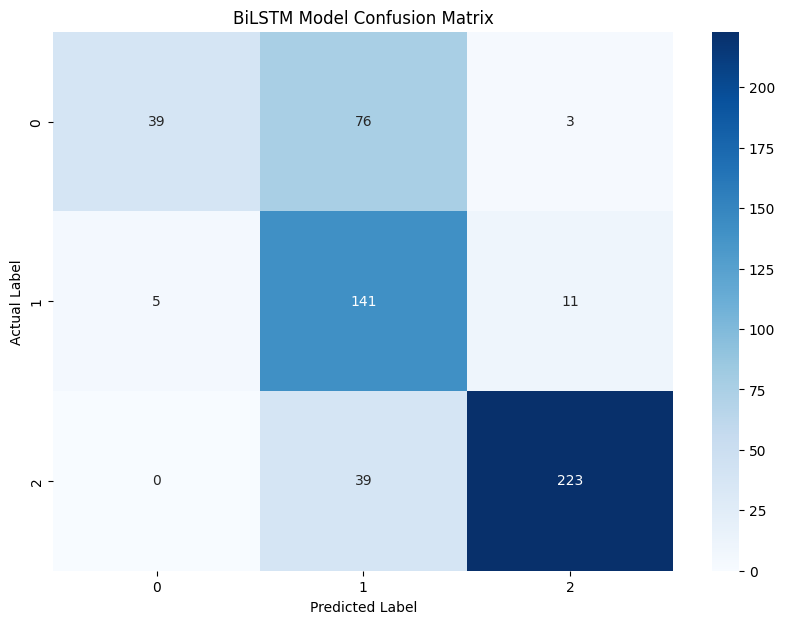

RNN
Epoch 1/10
54/54 [==============================] - 71s 1s/step - loss: 0.7189 - accuracy: 0.6579 - val_loss: 0.7280 - val_accuracy: 0.6558
Epoch 2/10
54/54 [==============================] - 70s 1s/step - loss: 0.7141 - accuracy: 0.6795 - val_loss: 0.6658 - val_accuracy: 0.7070
Epoch 3/10
54/54 [==============================] - 70s 1s/step - loss: 0.6559 - accuracy: 0.6865 - val_loss: 0.7133 - val_accuracy: 0.5977
Epoch 4/10
54/54 [==============================] - 82s 2s/step - loss: 0.6300 - accuracy: 0.7290 - val_loss: 0.7065 - val_accuracy: 0.6953
Epoch 5/10
54/54 [==============================] - 71s 1s/step - loss: 0.6266 - accuracy: 0.7232 - val_loss: 0.6402 - val_accuracy: 0.7070
Epoch 6/10
54/54 [==============================] - 68s 1s/step - loss: 0.5953 - accuracy: 0.7395 - val_loss: 0.6074 - val_accuracy: 0.7419
Epoch 7/10
54/54 [==============================] - 70s 1s/step - loss: 0.5831 - accuracy: 0.7453 - val_loss: 0.6148 - val_accuracy: 0.7209
Epoch 8/10
54/54

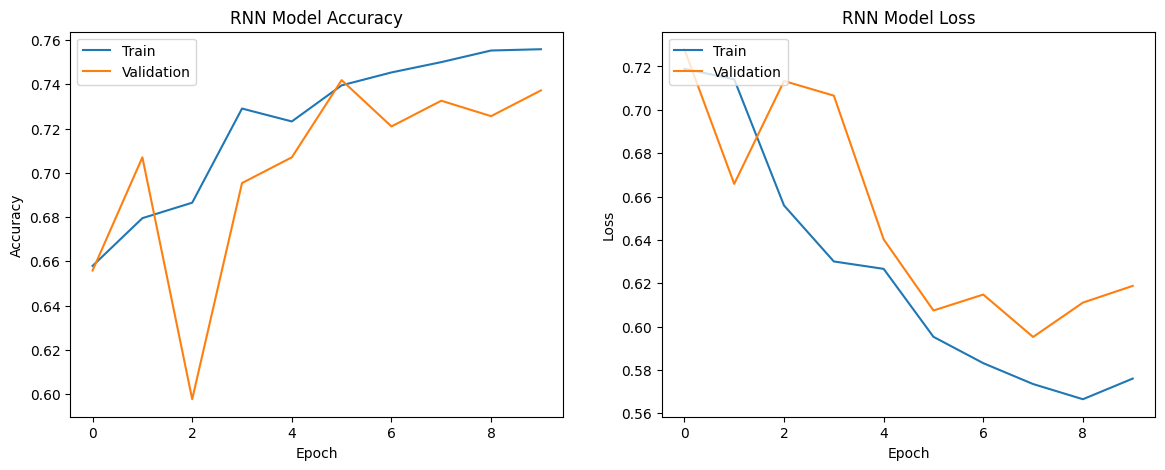

17/17 [==============================] - 3s 150ms/step
RNN Model
Test Accuracy : 0.7690875232774674
Test Precision : 0.7823271485704769
Test Recall : 0.7690875232774674


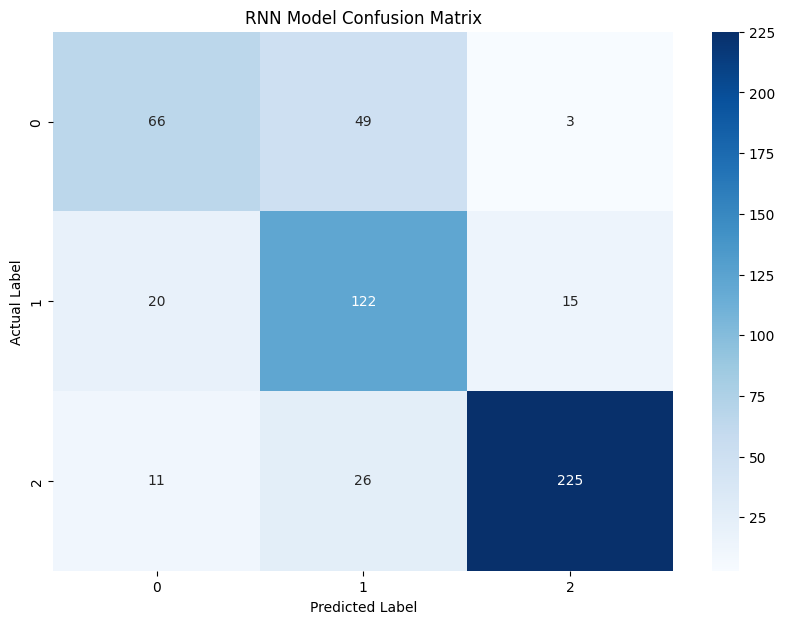

CNN
Epoch 1/10
54/54 [==============================] - 2s 10ms/step - loss: 1.0395 - accuracy: 0.4866 - val_loss: 0.9971 - val_accuracy: 0.4558
Epoch 2/10
54/54 [==============================] - 0s 5ms/step - loss: 0.9429 - accuracy: 0.5297 - val_loss: 0.8788 - val_accuracy: 0.6442
Epoch 3/10
54/54 [==============================] - 0s 6ms/step - loss: 0.8328 - accuracy: 0.6305 - val_loss: 0.7738 - val_accuracy: 0.6767
Epoch 4/10
54/54 [==============================] - 0s 6ms/step - loss: 0.7440 - accuracy: 0.6638 - val_loss: 0.7185 - val_accuracy: 0.6814
Epoch 5/10
54/54 [==============================] - 0s 5ms/step - loss: 0.6948 - accuracy: 0.6649 - val_loss: 0.6830 - val_accuracy: 0.6860
Epoch 6/10
54/54 [==============================] - 0s 5ms/step - loss: 0.6779 - accuracy: 0.6777 - val_loss: 0.6583 - val_accuracy: 0.7047
Epoch 7/10
54/54 [==============================] - 0s 5ms/step - loss: 0.6615 - accuracy: 0.6789 - val_loss: 0.6394 - val_accuracy: 0.6884
Epoch 8/10
54/5

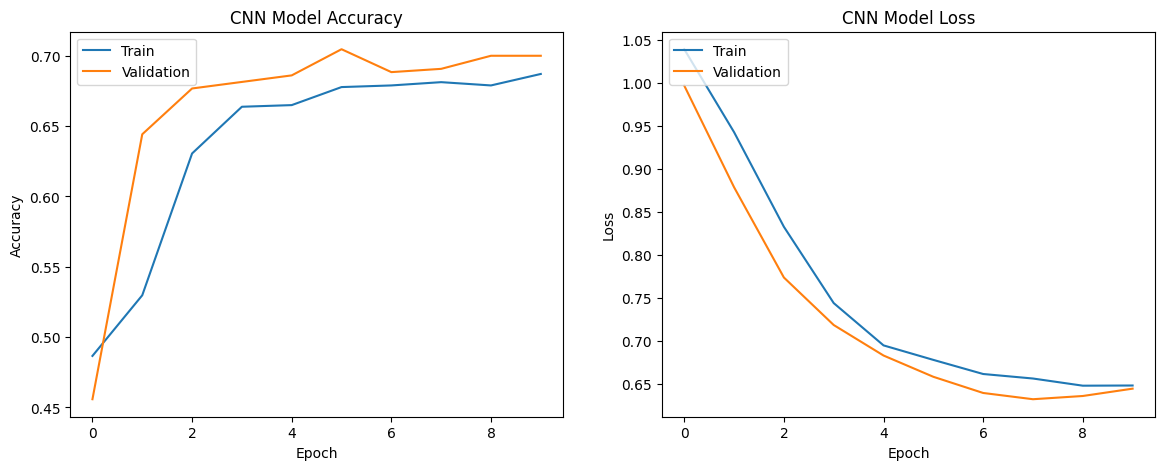

17/17 [==============================] - 0s 5ms/step
CNN Model
Test Accuracy : 0.6741154562383612
Test Precision : 0.5626062228989215
Test Recall : 0.6741154562383612


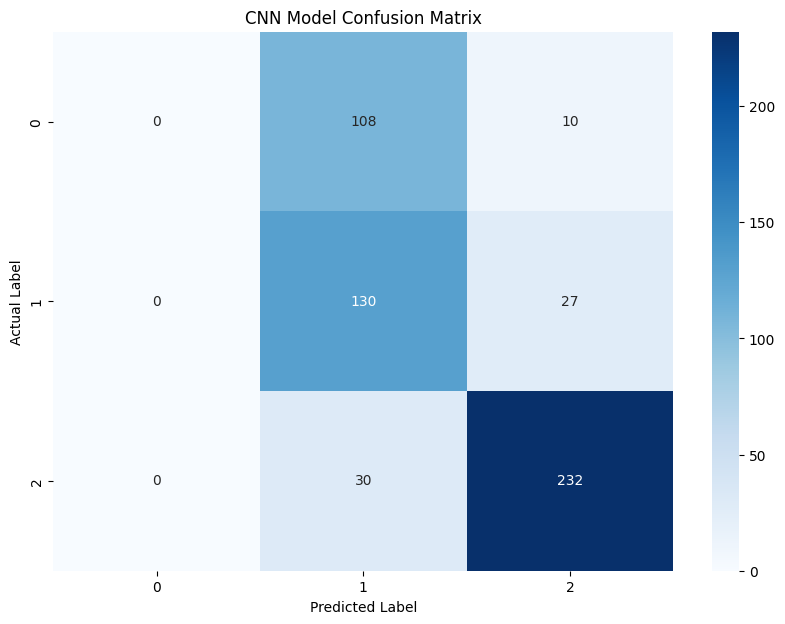

In [29]:
# Reshape the data for LSTM/GRU/CNN/RNN models
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# ANN Model
print("ANN")
ann_model = create_ann_model(X_train.shape[1])
history_ann = ann_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_ann, "ANN")
evaluate_model(ann_model, X_test, y_test, "ANN")

# LSTM Model
print("LSTM")
lstm_model = create_lstm_model(X_train_reshaped.shape[1])
history_lstm = lstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_lstm, "LSTM")
evaluate_model(lstm_model, X_test_reshaped, y_test, "LSTM")

# GRU Model
print("GRU")
gru_model = create_gru_model(X_train_reshaped.shape[1])
history_gru = gru_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_gru, "GRU")
evaluate_model(gru_model, X_test_reshaped, y_test, "GRU")

# BiLSTM Model
print("BiLSTM")
bilstm_model = create_bilstm_model(X_train_reshaped.shape[1])
history_bilstm = bilstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_bilstm, "BiLSTM")
evaluate_model(bilstm_model, X_test_reshaped, y_test, "BiLSTM")

# RNN Model
print("RNN")
rnn_model = create_rnn_model(X_train_reshaped.shape[1])
history_rnn = rnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_rnn, "RNN")
evaluate_model(rnn_model, X_test_reshaped, y_test, "RNN")

# CNN Model
print("CNN")
cnn_model = create_cnn_model(X_train_reshaped.shape[1])
history_cnn = cnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_cnn, "CNN")
evaluate_model(cnn_model, X_test_reshaped, y_test, "CNN")

In [ ]:
#@title Step 15: Train test split for Bert embedding
from sklearn.model_selection import train_test_split
X,y = df.processed_text,df.sentiment_class
Xtr,Xts,ytr,yts = train_test_split(X,y,test_size=0.2)
Xtr.shape,Xts.shape,ytr.shape,yts.shape

In [ ]:
# import numpy as np
# import tensorflow as tf
# from transformers import BertTokenizer, TFBertModel
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from sklearn.preprocessing import LabelEncoder

# encoder = LabelEncoder()
# ytr = encoder.fit_transform(ytr)
# yts = encoder.transform(yts)
# # Convert labels to one-hot encoding
# y_train_one_hot = to_categorical(ytr, num_classes=3)
# y_test_one_hot = to_categorical(yts, num_classes=3)

# # Load BERT tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')
# bert_model = TFBertModel.from_pretrained('distilbert-base-uncased')

# # Preprocess data
# def encode_texts(texts):
#     return tokenizer(texts, padding=True, truncation=True, return_tensors='tf')

# train_encodings = encode_texts(Xtr.to_list())
# test_encodings = encode_texts(Xts.to_list())

# # Get BERT embeddings
# def get_bert_embeddings(encodings):
#     outputs = bert_model(encodings['input_ids'], attention_mask=encodings['attention_mask'])
#     return outputs.last_hidden_state[:, 0, :].numpy()

# X_train_bert = get_bert_embeddings(train_encodings)
# X_test_bert = get_bert_embeddings(test_encodings)

# # Reshape the BERT embeddings for LSTM
# X_train_reshaped = np.expand_dims(X_train_bert, axis=1)  # Shape: (num_samples, 1, num_features)
# X_test_reshaped = np.expand_dims(X_test_bert, axis=1)    # Shape: (num_samples, 1, num_features)

# # Define LSTM model
# model = Sequential()
# model.add(LSTM(8, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
# model.add(Dense(3, activation='softmax'))  # Adjust the output layer to match the number of classes

# model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# # Train the model
# model.fit(X_train_reshaped, y_train_one_hot, epochs=10, batch_size=8, validation_data=(X_test_reshaped, y_test_one_hot))


In [ ]:
# ann_model.save_model('AspectAnalysisiANN')

In [ ]:
!pip install transformers


In [ ]:
#@title Step 8: For Fine tuning Preparing Data for Traing


In [ ]:
# from transformers import DistilBertTokenizerFast
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
# X = df['cleaned_text'].tolist()  # List of processed text
# y = df['sentiment_class'].tolist()  # List of sentiment class

In [ ]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# from transformers import DistilBertTokenizerFast

# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# # Tokenize the training and testing sets
# train_encodings = tokenizer(X_train, truncation=True, padding=True)
# test_encodings = tokenizer(X_test, truncation=True, padding=True)


In [ ]:
y_train

In [ ]:
# import tensorflow as tf

# train_dataset = tf.data.Dataset.from_tensor_slices((
#     dict(train_encodings),
#     y_train
# ))

# test_dataset = tf.data.Dataset.from_tensor_slices((
#     dict(test_encodings),
#     y_test
# ))


In [ ]:
# import tensorflow as tf
# from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification

# # Tokenize the text data
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# # Tokenize the text
# train_encodings = tokenizer(X_train, truncation=True, padding=True, return_tensors='tf')
# test_encodings = tokenizer(X_test, truncation=True, padding=True, return_tensors='tf')

# # Convert the labels to tensors and ensure they are of type int32
# train_labels = tf.convert_to_tensor(y_train, dtype=tf.int32)
# test_labels = tf.convert_to_tensor(y_test, dtype=tf.int32)

# # Create the TensorFlow datasets
# train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
# test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels))

# # Shuffle and batch the datasets
# train_dataset = train_dataset.shuffle(len(X_train)).batch(8)
# test_dataset = test_dataset.batch(16)

# # Load the model
# model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# # Define a simple loss function
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# # Compile the model
# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
# model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# # Train the model
# history = model.fit(train_dataset, epochs=3, validation_data=test_dataset, verbose = 1)

# # Save the model and tokenizer
# # model_path = '/content/drive/MyDrive/finetuned_model'
# # model.save_pretrained(model_path)
# # tokenizer.save_pretrained(model_path)


In [ ]:
# from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

# training_args = TFTrainingArguments(
#     output_dir='./results',          # output directory
#     num_train_epochs=3,              # total number of training epochs
#     per_device_train_batch_size=8,  # batch size per device during training
#     per_device_eval_batch_size=16,   # batch size for evaluation
#     warmup_steps=500,                # number of warmup steps for learning rate scheduler
#     weight_decay=0.01,               # strength of weight decay
#     logging_dir='./logs',            # directory for storing logs
#     logging_steps=10,
# )


In [ ]:
# with training_args.strategy.scope():
#     model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# trainer = TFTrainer(
#     model=model,                         # the instantiated 🤗 Transformers model to be trained
#     args=training_args,                  # training arguments, defined above
#     train_dataset=train_dataset,         # training dataset
#     eval_dataset=test_dataset             # evaluation dataset
# )

# trainer.train()

In [ ]:
# model.evaluate(test_dataset)

In [ ]:

# model.predict(test_dataset)

In [ ]:
# trainer.predict(test_dataset)[1].shape

In [ ]:
# output=model.predict(test_dataset)

In [ ]:
# from sklearn.metrics import confusion_matrix

# cm=confusion_matrix(y_test,output)
# cm

In [ ]:

# trainer.save_model('senti_model')


In [30]:
#@title Bert with Attention Mechanism

# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W_a = self.add_weight(name='W_a',
                                   shape=(input_shape[-1], input_shape[-1]),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=(input_shape[-1], input_shape[-1]),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=(input_shape[-1], 1),
                                   initializer='uniform',
                                   trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        score_first_part = K.dot(inputs, self.W_a)
        h_t = K.expand_dims(inputs, axis=1)
        score = K.tanh(score_first_part + h_t)
        attention_weights = K.softmax(K.dot(score, self.V_a), axis=1)
        context_vector = attention_weights * inputs
        context_vector = K.sum(context_vector, axis=1)
        return context_vector


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
# Define model creation functions
def create_ann_model(input_dim):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dense(64, activation='relu'))
    model.add(AttentionLayer())
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_lstm_model(input_dim):
    model = Sequential()
    model.add(LSTM(128, input_shape=(input_dim, 1), return_sequences=True))
    model.add(LSTM(64))
    model.add(AttentionLayer())
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_gru_model(input_dim):
    model = Sequential()
    model.add(GRU(128, input_shape=(input_dim, 1), return_sequences=True))
    model.add(GRU(64))
    model.add(AttentionLayer())
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_bilstm_model(input_dim):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(input_dim, 1)))
    model.add(Bidirectional(LSTM(64)))
    model.add(AttentionLayer())
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_rnn_model(input_dim):
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=(input_dim, 1), return_sequences=True))
    model.add(SimpleRNN(64))
    model.add(AttentionLayer())
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_cnn_model(input_dim):
    model = Sequential()
    model.add(Conv1D(128, 3, activation='relu', input_shape=(input_dim, 1)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(AttentionLayer())
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
# Evaluation and plotting functions
def plot_training_history(history, model_name):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    print(f"{model_name} Model")
    print("Test Accuracy : " + str(accuracy))
    print("Test Precision : " + str(precision))
    print("Test Recall : " + str(recall))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Model Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
# Train and evaluate ANN Model
ann_model = create_ann_model(X_train.shape[1])
history_ann = ann_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_ann, "ANN")
evaluate_model(ann_model, X_test, y_test, "ANN")

# Train and evaluate LSTM Model
lstm_model = create_lstm_model(X_train_reshaped.shape[1])
history_lstm = lstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_lstm, "LSTM")
evaluate_model(lstm_model, X_test_reshaped, y_test, "LSTM")

# Train and evaluate GRU Model
gru_model = create_gru_model(X_train_reshaped.shape[1])
history_gru = gru_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_gru, "GRU")
evaluate_model(gru_model, X_test_reshaped, y_test, "GRU")

# Train and evaluate BiLSTM Model
bilstm_model = create_bilstm_model(X_train_reshaped.shape[1])
history_bilstm = bilstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_bilstm, "BiLSTM")
evaluate_model(bilstm_model, X_test_reshaped, y_test, "BiLSTM")

# Train and evaluate RNN Model
rnn_model = create_rnn_model(X_train_reshaped.shape[1])
history_rnn = rnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_rnn, "RNN")
evaluate_model(rnn_model, X_test_reshaped, y_test, "RNN")

# Train and evaluate CNN Model
cnn_model = create_cnn_model(X_train_reshaped.shape[1])
history_cnn = cnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SyntaxError: incomplete input (<ipython-input-33-c8a257223425>, line 33)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch 1/10


54/54 [==============================] - 2s 8ms/step - loss: 1.0537 - accuracy: 0.4580 - val_loss: 1.0413 - val_accuracy: 0.4558
Epoch 2/10
54/54 [==============================] - 0s 5ms/step - loss: 0.9082 - accuracy: 0.5571 - val_loss: 0.7005 - val_accuracy: 0.6791
Epoch 3/10
54/54 [==============================] - 0s 5ms/step - loss: 0.6545 - accuracy: 0.6906 - val_loss: 0.6299 - val_accuracy: 0.7116
Epoch 4/10
54/54 [==============================] - 0s 7ms/step - loss: 0.5986 - accuracy: 0.7045 - val_loss: 0.6142 - val_accuracy: 0.7209
Epoch 5/10
54/54 [==============================] - 0s 7ms/step - loss: 0.5703 - accuracy: 0.7267 - val_loss: 0.6053 - val_accuracy: 0.7233
Epoch 6/10
54/54 [==============================] - 0s 7ms/step - loss: 0.5557 - accuracy: 0.7331 - val_loss: 0.6279 - val_accuracy: 0.7279
Epoch 7/10
54/54 [==============================] - 0s 7ms/step - loss: 0.5554 - accuracy: 0.7343 - val_loss: 0.6141 - val_accuracy: 0.7326
Epoch 8/10
54/54 [=============

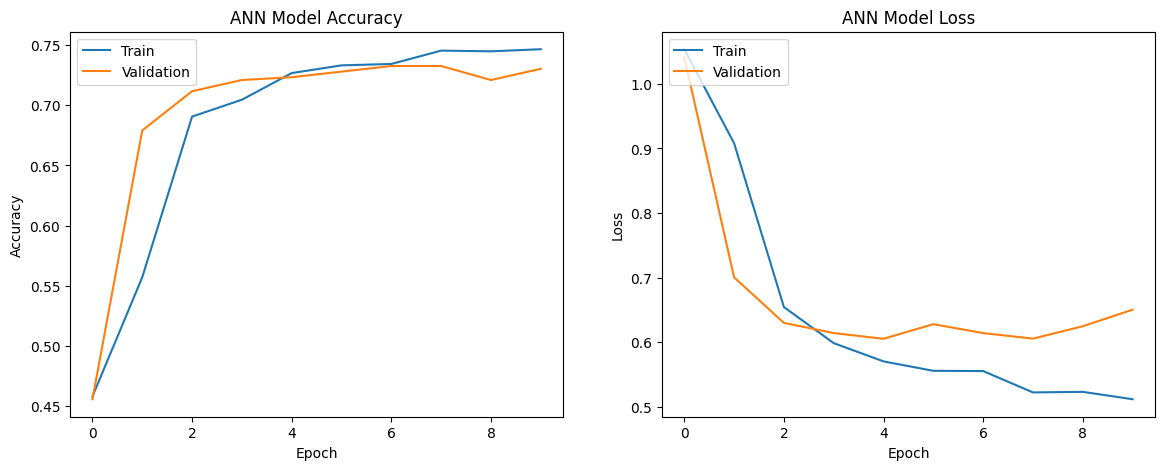

17/17 [==============================] - 0s 2ms/step
ANN Model
Test Accuracy : 0.7411545623836127
Test Precision : 0.6079734551887506
Test Recall : 0.7411545623836127


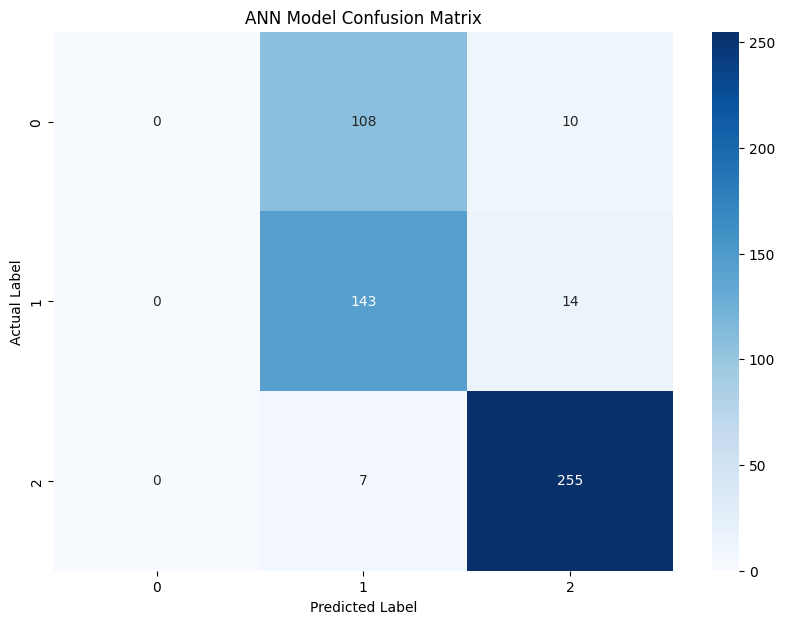

Epoch 1/10


54/54 [==============================] - 8s 65ms/step - loss: 1.0635 - accuracy: 0.4633 - val_loss: 1.0494 - val_accuracy: 0.4558
Epoch 2/10
54/54 [==============================] - 3s 64ms/step - loss: 1.0485 - accuracy: 0.4679 - val_loss: 1.0486 - val_accuracy: 0.4558
Epoch 3/10
54/54 [==============================] - 3s 52ms/step - loss: 1.0481 - accuracy: 0.4679 - val_loss: 1.0472 - val_accuracy: 0.4558
Epoch 4/10
54/54 [==============================] - 3s 48ms/step - loss: 1.0488 - accuracy: 0.4679 - val_loss: 1.0481 - val_accuracy: 0.4558
Epoch 5/10
54/54 [==============================] - 3s 48ms/step - loss: 1.0474 - accuracy: 0.4679 - val_loss: 1.0469 - val_accuracy: 0.4558
Epoch 6/10
54/54 [==============================] - 3s 48ms/step - loss: 1.0484 - accuracy: 0.4679 - val_loss: 1.0474 - val_accuracy: 0.4558
Epoch 7/10
54/54 [==============================] - 4s 69ms/step - loss: 1.0485 - accuracy: 0.4679 - val_loss: 1.0464 - val_accuracy: 0.4558
Epoch 8/10
54/54 [======

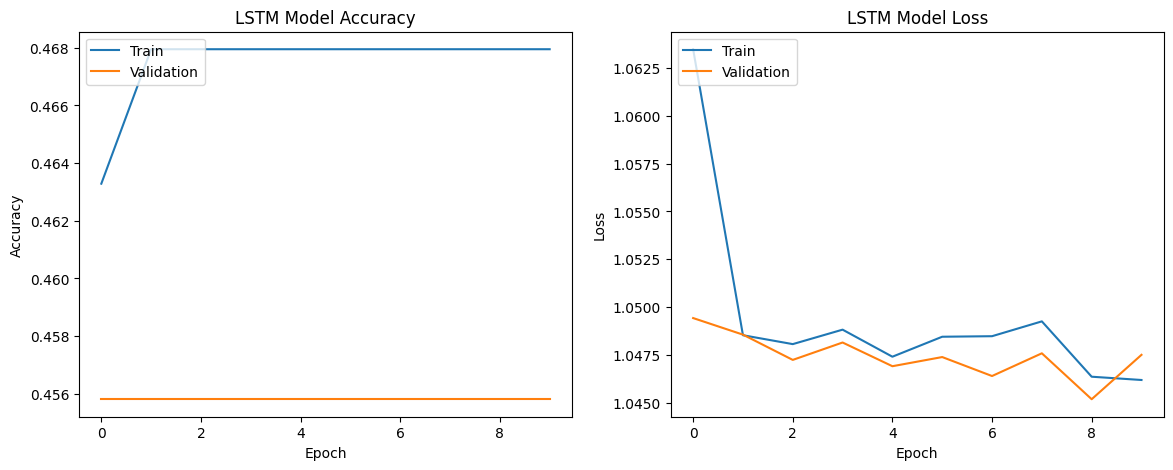

17/17 [==============================] - 1s 18ms/step
LSTM Model
Test Accuracy : 0.48789571694599626
Test Precision : 0.23804223061424773
Test Recall : 0.48789571694599626


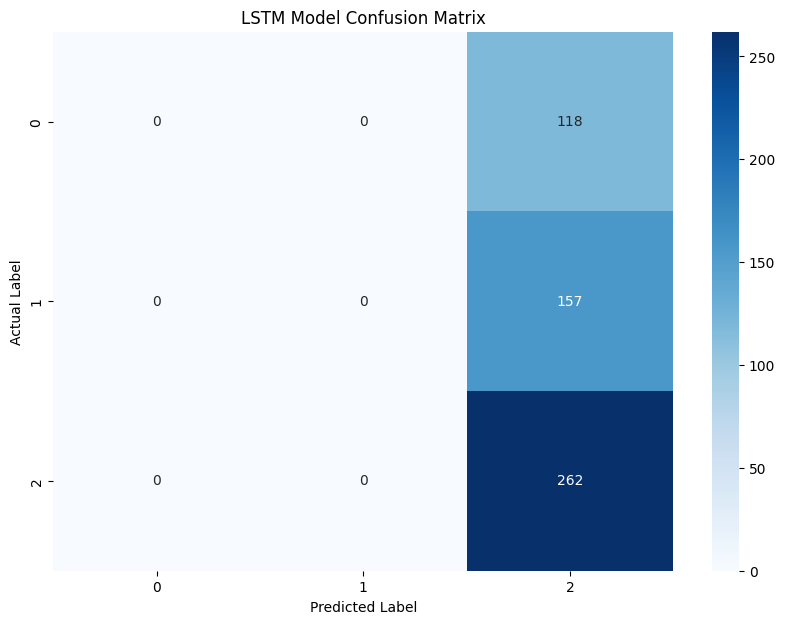

Epoch 1/10


54/54 [==============================] - 8s 65ms/step - loss: 1.0613 - accuracy: 0.4540 - val_loss: 1.0476 - val_accuracy: 0.4558
Epoch 2/10
54/54 [==============================] - 3s 48ms/step - loss: 1.0514 - accuracy: 0.4679 - val_loss: 1.0525 - val_accuracy: 0.4558
Epoch 3/10
54/54 [==============================] - 3s 49ms/step - loss: 1.0486 - accuracy: 0.4679 - val_loss: 1.0485 - val_accuracy: 0.4558
Epoch 4/10
54/54 [==============================] - 4s 66ms/step - loss: 1.0483 - accuracy: 0.4679 - val_loss: 1.0485 - val_accuracy: 0.4558
Epoch 5/10
54/54 [==============================] - 3s 51ms/step - loss: 1.0509 - accuracy: 0.4679 - val_loss: 1.0466 - val_accuracy: 0.4558
Epoch 6/10
54/54 [==============================] - 3s 48ms/step - loss: 1.0498 - accuracy: 0.4679 - val_loss: 1.0474 - val_accuracy: 0.4558
Epoch 7/10
54/54 [==============================] - 3s 48ms/step - loss: 1.0482 - accuracy: 0.4679 - val_loss: 1.0477 - val_accuracy: 0.4558
Epoch 8/10
54/54 [======

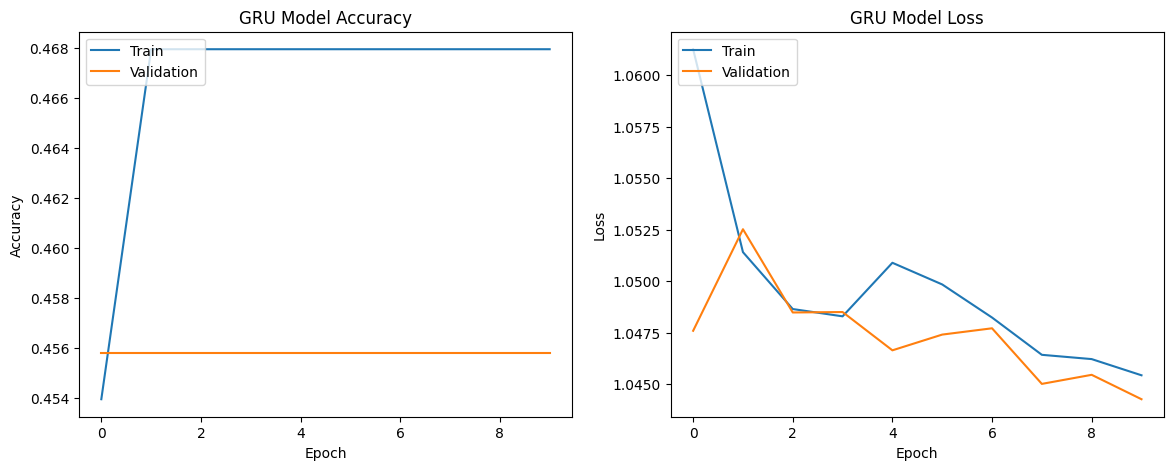

17/17 [==============================] - 1s 18ms/step
GRU Model
Test Accuracy : 0.48789571694599626
Test Precision : 0.23804223061424773
Test Recall : 0.48789571694599626


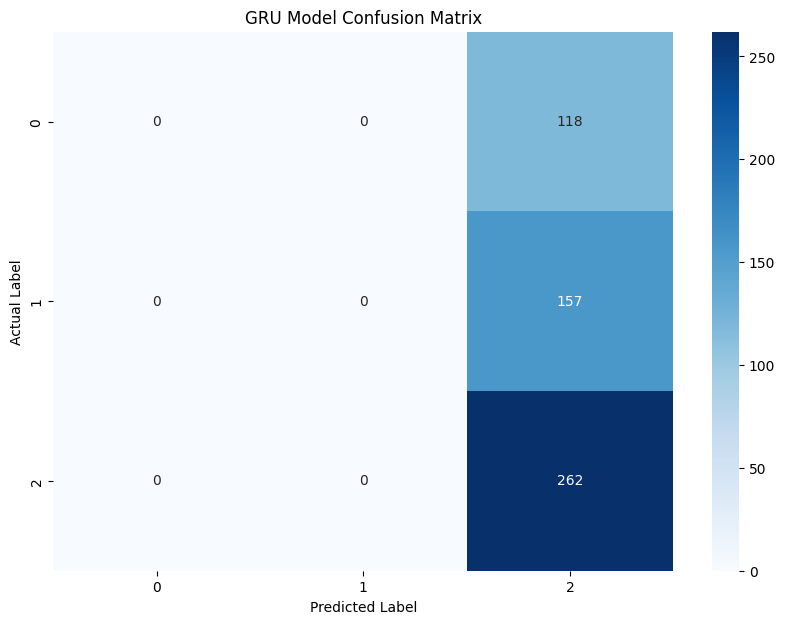

Epoch 1/10


54/54 [==============================] - 14s 128ms/step - loss: 1.0618 - accuracy: 0.4668 - val_loss: 1.0568 - val_accuracy: 0.4558
Epoch 2/10
54/54 [==============================] - 6s 102ms/step - loss: 1.0520 - accuracy: 0.4679 - val_loss: 1.0507 - val_accuracy: 0.4558
Epoch 3/10
54/54 [==============================] - 6s 108ms/step - loss: 1.0486 - accuracy: 0.4679 - val_loss: 1.0469 - val_accuracy: 0.4558
Epoch 4/10
54/54 [==============================] - 5s 100ms/step - loss: 1.0475 - accuracy: 0.4679 - val_loss: 1.0459 - val_accuracy: 0.4558
Epoch 5/10
54/54 [==============================] - 6s 111ms/step - loss: 1.0478 - accuracy: 0.4679 - val_loss: 1.0466 - val_accuracy: 0.4558
Epoch 6/10
54/54 [==============================] - 5s 100ms/step - loss: 1.0470 - accuracy: 0.4679 - val_loss: 1.0468 - val_accuracy: 0.4558
Epoch 7/10
54/54 [==============================] - 5s 102ms/step - loss: 1.0479 - accuracy: 0.4679 - val_loss: 1.0445 - val_accuracy: 0.4558
Epoch 8/10
54/54

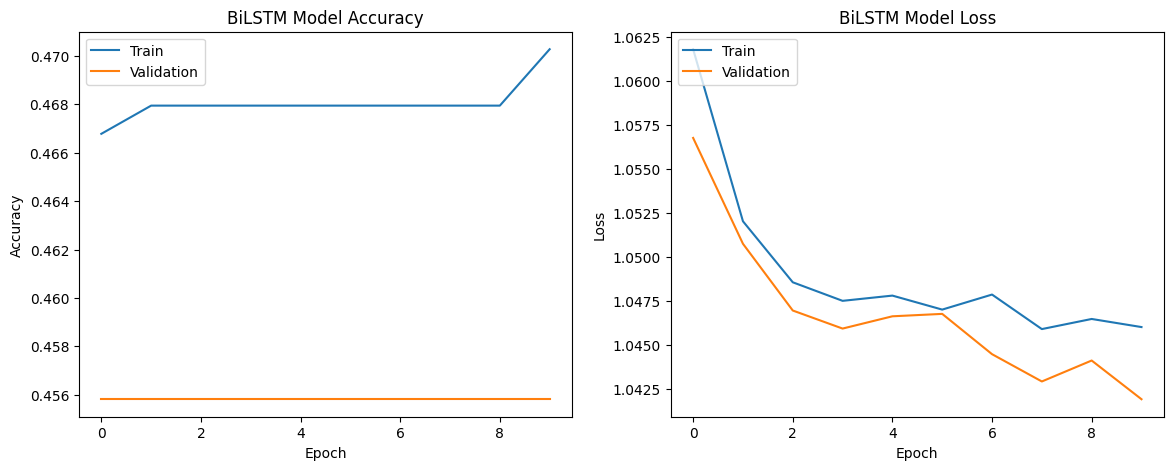

17/17 [==============================] - 3s 49ms/step
BiLSTM Model
Test Accuracy : 0.48789571694599626
Test Precision : 0.23804223061424773
Test Recall : 0.48789571694599626


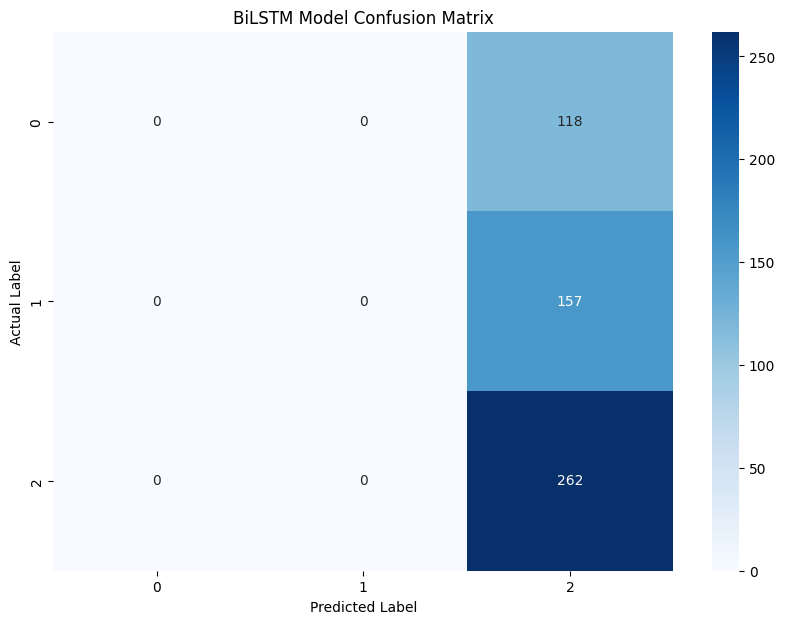

Epoch 1/10


54/54 [==============================] - 72s 1s/step - loss: 1.0815 - accuracy: 0.4307 - val_loss: 1.1509 - val_accuracy: 0.2395
Epoch 2/10
54/54 [==============================] - 67s 1s/step - loss: 1.0862 - accuracy: 0.3939 - val_loss: 1.1039 - val_accuracy: 0.4558
Epoch 3/10
54/54 [==============================] - 69s 1s/step - loss: 1.0764 - accuracy: 0.4341 - val_loss: 1.0565 - val_accuracy: 0.4372
Epoch 4/10
54/54 [==============================] - 68s 1s/step - loss: 1.0524 - accuracy: 0.4691 - val_loss: 1.0534 - val_accuracy: 0.4558
Epoch 5/10
54/54 [==============================] - 69s 1s/step - loss: 1.0531 - accuracy: 0.4709 - val_loss: 1.0531 - val_accuracy: 0.4558
Epoch 6/10
54/54 [==============================] - 71s 1s/step - loss: 1.0507 - accuracy: 0.4744 - val_loss: 1.0517 - val_accuracy: 0.4558
Epoch 7/10
54/54 [==============================] - 70s 1s/step - loss: 1.0518 - accuracy: 0.4679 - val_loss: 1.0559 - val_accuracy: 0.4558
Epoch 8/10
54/54 [=============

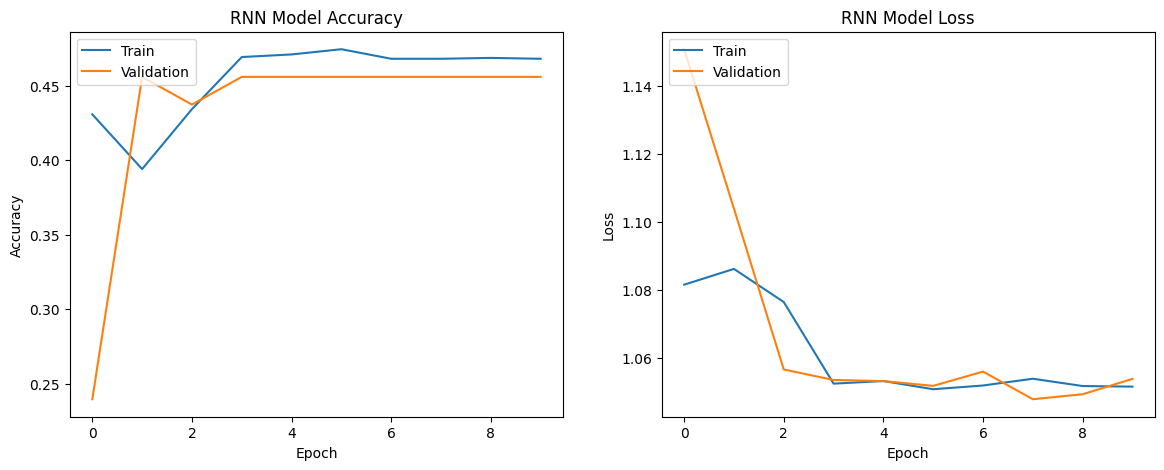

17/17 [==============================] - 3s 164ms/step
RNN Model
Test Accuracy : 0.48789571694599626
Test Precision : 0.23804223061424773
Test Recall : 0.48789571694599626


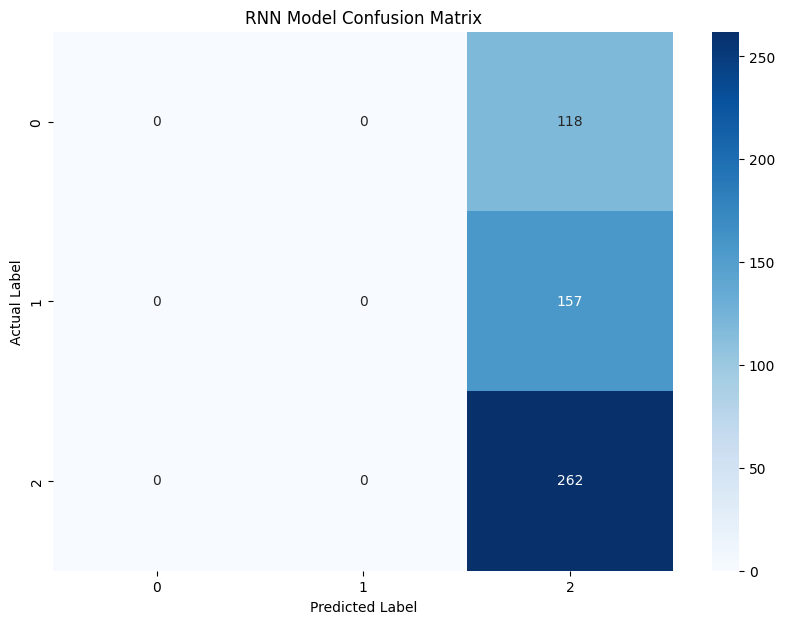

Epoch 1/10


54/54 [==============================] - 2s 10ms/step - loss: 1.0540 - accuracy: 0.4674 - val_loss: 1.0498 - val_accuracy: 0.4558
Epoch 2/10
54/54 [==============================] - 0s 6ms/step - loss: 1.0520 - accuracy: 0.4679 - val_loss: 1.0474 - val_accuracy: 0.4558
Epoch 3/10
54/54 [==============================] - 0s 6ms/step - loss: 1.0512 - accuracy: 0.4604 - val_loss: 1.0501 - val_accuracy: 0.4558
Epoch 4/10
54/54 [==============================] - 0s 6ms/step - loss: 1.0544 - accuracy: 0.4679 - val_loss: 1.0475 - val_accuracy: 0.4558
Epoch 5/10
54/54 [==============================] - 0s 6ms/step - loss: 1.0555 - accuracy: 0.4679 - val_loss: 1.0535 - val_accuracy: 0.4558
Epoch 6/10
54/54 [==============================] - 0s 6ms/step - loss: 1.0511 - accuracy: 0.4679 - val_loss: 1.0496 - val_accuracy: 0.4558
Epoch 7/10
54/54 [==============================] - 0s 6ms/step - loss: 1.0486 - accuracy: 0.4679 - val_loss: 1.0514 - val_accuracy: 0.4558
Epoch 8/10
54/54 [============

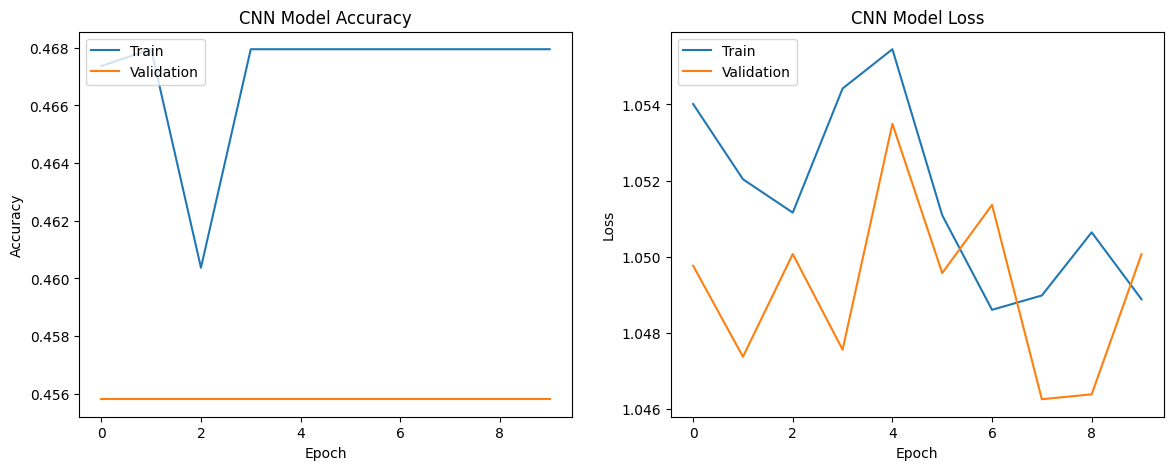

17/17 [==============================] - 0s 2ms/step
CNN Model
Test Accuracy : 0.48789571694599626
Test Precision : 0.23804223061424773
Test Recall : 0.48789571694599626


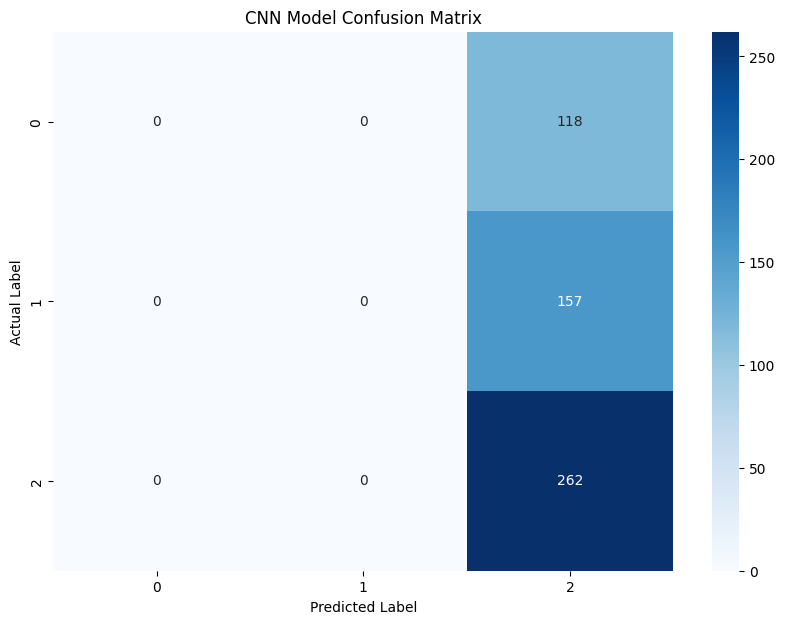

In [35]:
#@title Step 2: Preprocess and Generate BERT Embeddings
# def get_distilbert_embedding(text):
#     # Tokenize the text
#     inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')

#     # Generate embeddings
#     with torch.no_grad():
#         outputs = model(**inputs)

#     # Take the mean of the token embeddings to get a single embedding vector
#     embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
#     return embeddings

# Apply the function to the dataset
df['distilbert_embedding'] = df['processed_text'].apply(get_distilbert_embedding)

#@title Step 3: Split Data for Training and Testing
import numpy as np
from sklearn.model_selection import train_test_split

# Convert the list of embeddings to a numpy array
X = np.array(df['distilbert_embedding'].tolist())
y = df['sentiment_class'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for LSTM, GRU, BiLSTM, RNN, and CNN models
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

#@title Bert with Attention Mechanism

# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W_a = self.add_weight(name='W_a',
                                   shape=(input_shape[-1], input_shape[-1]),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=(input_shape[-1], input_shape[-1]),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=(input_shape[-1], 1),
                                   initializer='uniform',
                                   trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        score_first_part = K.dot(inputs, self.W_a)
        h_t = K.expand_dims(inputs, axis=1)
        score = K.tanh(score_first_part + h_t)
        attention_weights = K.softmax(K.dot(score, self.V_a), axis=1)
        context_vector = attention_weights * inputs
        context_vector = K.sum(context_vector, axis=1)
        return context_vector

# Define model creation functions
def create_ann_model(input_dim):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dense(64, activation='relu'))
    model.add(AttentionLayer())
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_lstm_model(input_dim):
    model = Sequential()
    model.add(LSTM(128, input_shape=(input_dim, 1), return_sequences=True))
    model.add(LSTM(64))
    model.add(AttentionLayer())
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_gru_model(input_dim):
    model = Sequential()
    model.add(GRU(128, input_shape=(input_dim, 1), return_sequences=True))
    model.add(GRU(64))
    model.add(AttentionLayer())
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_bilstm_model(input_dim):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(input_dim, 1)))
    model.add(Bidirectional(LSTM(64)))
    model.add(AttentionLayer())
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_rnn_model(input_dim):
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=(input_dim, 1), return_sequences=True))
    model.add(SimpleRNN(64))
    model.add(AttentionLayer())
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_cnn_model(input_dim):
    model = Sequential()
    model.add(Conv1D(128, 3, activation='relu', input_shape=(input_dim, 1)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(AttentionLayer())
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Evaluation and plotting functions
def plot_training_history(history, model_name):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    print(f"{model_name} Model")
    print("Test Accuracy : " + str(accuracy))
    print("Test Precision : " + str(precision))
    print("Test Recall : " + str(recall))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Model Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Train and evaluate ANN Model
ann_model = create_ann_model(X_train.shape[1])
history_ann = ann_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_ann, "ANN")
evaluate_model(ann_model, X_test, y_test, "ANN")

# Train and evaluate LSTM Model
lstm_model = create_lstm_model(X_train_reshaped.shape[1])
history_lstm = lstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_lstm, "LSTM")
evaluate_model(lstm_model, X_test_reshaped, y_test, "LSTM")

# Train and evaluate GRU Model
gru_model = create_gru_model(X_train_reshaped.shape[1])
history_gru = gru_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_gru, "GRU")
evaluate_model(gru_model, X_test_reshaped, y_test, "GRU")

# Train and evaluate BiLSTM Model
bilstm_model = create_bilstm_model(X_train_reshaped.shape[1])
history_bilstm = bilstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_bilstm, "BiLSTM")
evaluate_model(bilstm_model, X_test_reshaped, y_test, "BiLSTM")

# Train and evaluate RNN Model
rnn_model = create_rnn_model(X_train_reshaped.shape[1])
history_rnn = rnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_rnn, "RNN")
evaluate_model(rnn_model, X_test_reshaped, y_test, "RNN")

# Train and evaluate CNN Model
cnn_model = create_cnn_model(X_train_reshaped.shape[1])
history_cnn = cnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)
plot_training_history(history_cnn, "CNN")
evaluate_model(cnn_model, X_test_reshaped, y_test, "CNN")
